# Time Series Analysis of Pennsylvania and Illinois Weather, Energy Consumption, and Flu Contagion (2013–2015)

## Introduction

In this project, we aim to identify and explore temporal patterns, correlations, and potential causal relationships between weather conditions, energy consumption, and flu contagion across Pennsylvania and Illinois from 2013 to 2015. By analyzing these interrelated datasets, we hope to derive insights that can inform stakeholders in public health and energy management.

### Objectives
- Analyze daily/hourly weather data to identify trends and seasonal patterns.
- Examine hourly energy consumption data to understand usage patterns in relation to weather.
- Investigate weekly flu contagion data to determine correlations with weather.
- Utilize statistical modeling techniques to assess interdependencies among the datasets.

### Key Datasets
1. **USA Weather Dataset (2013–2015)**:
   - Temporal granularity: Hourly
   - Variables of interest: Temperature.

2. **PJM Historic Energy Consumption**:
   - Temporal granularity: Hourly
   - Scope: Energy usage data for Pennsylvania (Duquesne Light) and Illinois (ComEd).

3. **Flu Contagion Dataset by State (2013–2015)**:
   - Temporal granularity: Weekly
   - Variables: Influenza-like illness (ILI) [activity](https://www.cdc.gov/mmwr/volumes/67/wr/mm6722a4.htm) in the USA.

This notebook will guide you through the data ingestion, preparation, exploratory data analysis (EDA), time series modeling, and visualization phases of the project.

In [1]:
# Data Manipulation and Analysis
import pandas as pd  # For data manipulation and analysis using DataFrames
import numpy as np   # For numerical operations and handling arrays
from sklearn.preprocessing import MinMaxScaler # For scaling data

# Statistical Analysis
import scipy.stats as stats  # For statistical tests and distributions
from statsmodels.tsa.stattools import adfuller  # For stationarity tests
from scipy.fft import fft, fftfreq, fftshift # For Fourier analysis

# Time Series Analysis
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA modeling
from statsmodels.tsa.seasonal import seasonal_decompose  # For seasonal decomposition of time series
from statsmodels.tsa.seasonal import MSTL    # For seasonal decomposition of time series

# Machine Learning Libraries
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing sets
from sklearn.ensemble import RandomForestRegressor  # For regression tasks
import xgboost as xgb  # For gradient boosting models

# Visualization Libraries
import matplotlib.pyplot as plt  # For creating static visualizations
import seaborn as sns            # For enhanced statistical visualizations
import plotly.express as px      # For interactive plots (optional)

# Date and Time Handling
from datetime import datetime     # For date/time manipulation
from pytz import timezone       # For time zone handling
import holidays                # For handling holidays


## Data Ingestion/Wrangling

We begin by retrieving the relevant dataframes for our job.

Weather dataset, granularity in hours. We are only interested in two states. This dataset is the one imposing the time dataframe in our study. As we are interested in its influence on energy consumption and flu activity, we isolate only the temperature (originally in Kelvin degrees).

Note: for this particular dataset we only have Pittsburgh and Chicago as representative cities for the states of Pennsylvania and Illinois respectivelly.

In [2]:
path = r'sources/historical_hourly_weather_data- 2012_to_2017/temperature.csv'
df = pd.read_csv(path)
display(df)

datetime   Vancouver    Portland  San Francisco     Seattle  \
0      2012-10-01 12:00:00         NaN         NaN            NaN         NaN   
1      2012-10-01 13:00:00  284.630000  282.080000     289.480000  281.800000   
2      2012-10-01 14:00:00  284.629041  282.083252     289.474993  281.797217   
3      2012-10-01 15:00:00  284.626998  282.091866     289.460618  281.789833   
4      2012-10-01 16:00:00  284.624955  282.100481     289.446243  281.782449   
...                    ...         ...         ...            ...         ...   
45248  2017-11-29 20:00:00         NaN  282.000000            NaN  280.820000   
45249  2017-11-29 21:00:00         NaN  282.890000            NaN  281.650000   
45250  2017-11-29 22:00:00         NaN  283.390000            NaN  282.750000   
45251  2017-11-29 23:00:00         NaN  283.020000            NaN  282.960000   
45252  2017-11-30 00:00:00         NaN  282.280000            NaN  283.040000   

       Los Angeles   San Diego   Las Vegas     Phoenix  Albuquerque  ...  \
0              NaN         NaN         NaN         NaN          NaN  ...   
1       291.870000  291.530000  293.410000  296.600000   285.120000  ...   
2       291.868186  291.533501  293.403141  296.608509   285.154558  ...   
3       291.862844  291.543355  293.392177  296.631487   285.233952  ...   
4       291.857503  291.553209  293.381213  296.654466   285.313345  ...   
...            ...         ...         ...         ...          ...  ...   
45248   293.550000  292.150000  289.540000  294.710000   285.720000  ...   
45249   295.680000  292.740000  290.610000  295.590000   286.450000  ...   
45250   295.960000  292.580000  291.340000  296.250000   286.440000  ...   
45251   295.650000  292.610000  292.150000  297.150000   286.140000  ...   
45252   294.930000  291.400000  291.640000  297.150000   284.700000  ...   

       Philadelphia    New York    Montreal      Boston   Beersheba  \
0               NaN         NaN         NaN         NaN         NaN   
1        285.630000  288.220000  285.830000  287.170000  307.590000   
2        285.663208  288.247676  285.834650  287.186092  307.590000   
3        285.756824  288.326940  285.847790  287.231672  307.391513   
4        285.850440  288.406203  285.860929  287.277251  307.145200   
...             ...         ...         ...         ...         ...   
45248    290.240000         NaN  275.130000  288.080000         NaN   
45249    289.240000         NaN  274.130000  286.020000         NaN   
45250    286.780000         NaN  273.480000  283.940000         NaN   
45251    284.570000         NaN  272.480000  282.170000         NaN   
45252    283.420000         NaN  271.800000  280.650000         NaN   

       Tel Aviv District       Eilat  Haifa  Nahariyya  Jerusalem  
0                    NaN  309.100000    NaN        NaN        NaN  
1             305.470000  310.580000  304.4      304.4      303.5  
2             304.310000  310.495769  304.4      304.4      303.5  
3             304.281841  310.411538  304.4      304.4      303.5  
4             304.238015  310.327308  304.4      304.4      303.5  
...                  ...         ...    ...        ...        ...  
45248                NaN         NaN    NaN        NaN        NaN  
45249                NaN         NaN    NaN        NaN        NaN  
45250                NaN         NaN    NaN        NaN        NaN  
45251                NaN         NaN    NaN        NaN        NaN  
45252                NaN         NaN    NaN        NaN        NaN  

[45253 rows x 37 columns]

In [3]:
df_temperature = df[['datetime', 'Pittsburgh', 'Chicago']].copy()

# export it as CSV
df_temperature.to_csv('raw_temperature.csv', index=False)

# change col names
df_temperature.columns = ['datetime', 'pittsburgh_temp', 'chicago_temp']

# change 'datetime' format
df_temperature['datetime'] = pd.to_datetime(df_temperature['datetime'])
# localize the 'datetime' column to GMT (UTC)
df_temperature['datetime'] = df_temperature['datetime'].dt.tz_localize('GMT')
# convert to New York timezone
df_temperature['datetime'] = df_temperature['datetime'].dt.tz_convert('America/New_York')

# convert temperatures from K to C
df_temperature['pittsburgh_temp'] = df_temperature['pittsburgh_temp'] - 273.15
df_temperature['chicago_temp'] = df_temperature['chicago_temp'] - 273.15

display(df_temperature)

datetime  pittsburgh_temp  chicago_temp
0     2012-10-01 08:00:00-04:00              NaN           NaN
1     2012-10-01 09:00:00-04:00         7.850000     10.860000
2     2012-10-01 10:00:00-04:00         7.874767     10.904691
3     2012-10-01 11:00:00-04:00         7.938319     11.027412
4     2012-10-01 12:00:00-04:00         8.001870     11.150133
...                         ...              ...           ...
45248 2017-11-29 15:00:00-05:00        12.150000      8.190000
45249 2017-11-29 16:00:00-05:00        12.180000      8.540000
45250 2017-11-29 17:00:00-05:00         9.760000      7.920000
45251 2017-11-29 18:00:00-05:00         6.990000      6.910000
45252 2017-11-29 19:00:00-05:00         6.040000      5.310000

[45253 rows x 3 columns]

In [4]:
# for completitude we count NaNs and duplicates
# the few NaNs will be absorbed later on the average
print(f'## df_temperature NaN values: \n{df_temperature.isna().sum()}\n')
print(f'## df_temperature dates duplicated values: {df_temperature['datetime'].duplicated().sum()}')

## df_temperature NaN values: 
datetime           0
pittsburgh_temp    3
chicago_temp       3
dtype: int64

## df_temperature dates duplicated values: 0


In [5]:
# check unique values in temperature dataframe
unique_years_temperature = df_temperature['datetime'].dt.year.unique()
print("## Unique years in temperature dataframe:", unique_years_temperature)

unique_months_temperature = df_temperature['datetime'].dt.month.unique()
print("## Unique months in temperature dataframe:", unique_months_temperature)

unique_days_temperature = df_temperature['datetime'].dt.day.unique()
print("## Unique days in temperature dataframe:", unique_days_temperature)

unique_hour_temperature = df_temperature['datetime'].dt.hour.unique()
print("## Unique hour in temperature dataframe:", unique_hour_temperature)

## Unique years in temperature dataframe: [2012 2013 2014 2015 2016 2017]
## Unique months in temperature dataframe: [10 11 12  1  2  3  4  5  6  7  8  9]
## Unique days in temperature dataframe: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
## Unique hour in temperature dataframe: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23  0  1  2  3  4  5  6  7]


### Energy Load Data Wrangling

For the electrical energy consumption by local statal companies, we have a dataset for Duquesne Light Co. (DUQ) and Commonwealth Edison (ComEd). The problem (for our analysis) is the interconnected energy distribution network: we have regional (not city) energy load:

**Duquesne Light Company** primarily provides electricity to southwestern Pennsylvania, specifically serving the greater Pittsburgh area and parts of Allegheny and Beaver counties. The utility serves approximately 600,000 customers across an 817 square mile service area, with about 90% of its service area being residential [[1]](https://www.electricchoice.com/utilities/duquesne-light/), [[2]](https://www.chooseenergy.com/utilities/duquesne-light-co-pa/), [[3]](https://electricityplans.com/pennsylvania/utilities/duquesne-light-company/).

**Commonwealth Edison (ComEd)** is the largest electric utility in Illinois, serving more than 4,000,000 customers across northern Illinois, which represents approximately 70% of the state's population. The company's service territory covers about 11,400 square miles, stretching from the Wisconsin border to the north, Iowa border to the west, Indiana border to the east, and as far south as Iroquois County. ComEd, a unit of Exelon Corporation, manages over 90,000 miles of power lines and has been providing electric service to the region for more than 100 years [[4]](https://www.exeloncorp.com/companies/comed), [[5]](https://www.ilcma.org/friends-of-ilcma/comed/), [[6]](https://en.wikipedia.org/wiki/Commonwealth_Edison).

To bridge the connection between weather and energy datasets, we can hypothesize that state-level temperature trends are closely aligned with the temperature variations observed in their primary metropolitan areas. This assumption allows us to use city temperature data as a reliable proxy for regional weather conditions, facilitating more granular analysis of energy consumption patterns in relation to temperature fluctuations.

In [6]:
# import energy datasets
path1 = r'sources\hourly_energy_consumption\DUQ_hourly.csv'
path2 = r'sources\hourly_energy_consumption\COMED_hourly.csv'
df_pennsylvania = pd.read_csv(path1)
df_illinois = pd.read_csv(path2)

# check df structure
display(df_pennsylvania.head())
print()
display(df_illinois.head())

Datetime  DUQ_MW
0  2005-12-31 01:00:00  1458.0
1  2005-12-31 02:00:00  1377.0
2  2005-12-31 03:00:00  1351.0
3  2005-12-31 04:00:00  1336.0
4  2005-12-31 05:00:00  1356.0

Datetime  COMED_MW
0  2011-12-31 01:00:00    9970.0
1  2011-12-31 02:00:00    9428.0
2  2011-12-31 03:00:00    9059.0
3  2011-12-31 04:00:00    8817.0
4  2011-12-31 05:00:00    8743.0

Although [Pennsylvania](https://www.macrotrends.net/global-metrics/states/pennsylvania/population) and [Illinois](https://www.macrotrends.net/global-metrics/states/illinois/population) have similar populations, there is a magnitude order in energy load.

| Year | Pennsylvania | Illinois    |
|------|--------------|-------------|
| 2012 | 12,763,536   | 12,875,280  |
| 2013 | 12,773,801   | 12,882,250  |
| 2014 | 12,787,209   | 12,880,552  |
| 2015 | 12,802,503   | 12,859,585  |
| 2016 | 12,784,227   | 12,821,709  |
| 2017 | 12,805,537   | 12,779,893  |


So to normalize the electric energy load, we will need to divide by the amount of clients of each company:

In [7]:
# manipulate energy datasets
df_pennsylvania_pop = df_pennsylvania.copy()
df_pennsylvania_pop['Duquesne_kW'] = df_pennsylvania_pop['DUQ_MW'] / 600 # divide by customers and convert to kW
df_pennsylvania_pop.drop(columns='DUQ_MW', inplace=True)
display(df_pennsylvania_pop)
print()

df_illinois_pop = df_illinois.copy()
df_illinois_pop['ComEdison_kW'] = df_illinois_pop['COMED_MW'] / 4000 # divide by customers and convert to kW
df_illinois_pop.drop(columns='COMED_MW', inplace=True)
display(df_illinois_pop)

Datetime  Duquesne_kW
0       2005-12-31 01:00:00     2.430000
1       2005-12-31 02:00:00     2.295000
2       2005-12-31 03:00:00     2.251667
3       2005-12-31 04:00:00     2.226667
4       2005-12-31 05:00:00     2.260000
...                     ...          ...
119063  2018-01-01 20:00:00     3.270000
119064  2018-01-01 21:00:00     3.233333
119065  2018-01-01 22:00:00     3.151667
119066  2018-01-01 23:00:00     3.033333
119067  2018-01-02 00:00:00     2.868333

[119068 rows x 2 columns]

Datetime  ComEdison_kW
0      2011-12-31 01:00:00       2.49250
1      2011-12-31 02:00:00       2.35700
2      2011-12-31 03:00:00       2.26475
3      2011-12-31 04:00:00       2.20425
4      2011-12-31 05:00:00       2.18575
...                    ...           ...
66492  2018-01-01 20:00:00       3.46450
66493  2018-01-01 21:00:00       3.43950
66494  2018-01-01 22:00:00       3.40675
66495  2018-01-01 23:00:00       3.33400
66496  2018-01-02 00:00:00       3.20400

[66497 rows x 2 columns]

There are some duplicated values, much possible due to summer time:

In [8]:
# check missing values
print(f'## Pensylvania missing values: \n{df_pennsylvania_pop.isna().sum()}')
print()
print(f'## Illinois missing values: \n{df_illinois_pop.isna().sum()}')
print()

# check duplicates
print(f'## Pensylvania duplicated values: \n{df_pennsylvania_pop['Datetime'].duplicated().sum()}')
print()
print(f'## Illinois duplicated values: \n{df_illinois_pop['Datetime'].duplicated().sum()}')

## Pensylvania missing values: 
Datetime       0
Duquesne_kW    0
dtype: int64

## Illinois missing values: 
Datetime        0
ComEdison_kW    0
dtype: int64

## Pensylvania duplicated values: 
4

## Illinois duplicated values: 
4


In [9]:
# remove duplicates
df_pennsylvania_pop = df_pennsylvania_pop.drop_duplicates(subset='Datetime')
df_illinois_pop = df_illinois_pop.drop_duplicates(subset='Datetime')

# check duplicates
print(f'## Pensylvania duplicated values: \n{df_pennsylvania_pop['Datetime'].duplicated().sum()}')
print()
print(f'## Illinois duplicated values: \n{df_illinois_pop['Datetime'].duplicated().sum()}')

## Pensylvania duplicated values: 
0

## Illinois duplicated values: 
0


In [10]:
# ensure 'Datetime' is in datetime format
df_pennsylvania_pop['Datetime'] = pd.to_datetime(df_pennsylvania_pop['Datetime'])
df_illinois_pop['Datetime'] = pd.to_datetime(df_illinois_pop['Datetime'])

# localize the 'Datetime' column to GMT (UTC)
df_pennsylvania_pop['Datetime'] = df_pennsylvania_pop['Datetime'].dt.tz_localize('GMT')
df_illinois_pop['Datetime'] = df_illinois_pop['Datetime'].dt.tz_localize('GMT')

# check unique years in Pennsylvania dataframe
unique_years_pennsylvania = df_pennsylvania_pop['Datetime'].dt.year.unique()
print("## Unique years in Pennsylvania dataframe:", unique_years_pennsylvania)

# check unique years in Illinois dataframe
unique_years_illinois = df_illinois_pop['Datetime'].dt.year.unique()
print("## Unique years in Illinois dataframe:", unique_years_illinois)

## Unique years in Pennsylvania dataframe: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
## Unique years in Illinois dataframe: [2011 2012 2013 2014 2015 2016 2017 2018]


We need only the time period specified by the weather data. We achieve that with a left inner join on the temperature dataset:

In [11]:
# merge temp and duqesne
df_energy = pd.merge(df_temperature, df_pennsylvania_pop, left_on='datetime', right_on='Datetime', how='inner')
df_energy.drop(columns='Datetime', inplace=True)

# merge with common edison
df_energy = pd.merge(df_energy, df_illinois_pop, left_on='datetime', right_on='Datetime', how='inner')
df_energy.drop(columns='Datetime', inplace=True)

# check shape
display(df_energy)
display(f'## Shape of df_temperature:{df_temperature.shape}')
display(f'## Shape of df_energy:{df_energy.shape}')

# check missin values
print(f'## df_energy missing values: \n{df_energy.isna().sum()}')

datetime  pittsburgh_temp  chicago_temp  Duquesne_kW  \
0     2012-10-01 08:00:00-04:00              NaN           NaN     2.716667   
1     2012-10-01 09:00:00-04:00         7.850000     10.860000     2.733333   
2     2012-10-01 10:00:00-04:00         7.874767     10.904691     2.745000   
3     2012-10-01 11:00:00-04:00         7.938319     11.027412     2.716667   
4     2012-10-01 12:00:00-04:00         8.001870     11.150133     2.711667   
...                         ...              ...           ...          ...   
45241 2017-11-29 15:00:00-05:00        12.150000      8.190000     2.690000   
45242 2017-11-29 16:00:00-05:00        12.180000      8.540000     2.676667   
45243 2017-11-29 17:00:00-05:00         9.760000      7.920000     2.591667   
45244 2017-11-29 18:00:00-05:00         6.990000      6.910000     2.461667   
45245 2017-11-29 19:00:00-05:00         6.040000      5.310000     2.306667   

       ComEdison_kW  
0           2.82550  
1           2.85650  
2           2.88050  
3           2.89350  
4           2.87225  
...             ...  
45241       3.04275  
45242       2.99950  
45243       2.92025  
45244       2.78700  
45245       2.59775  

[45246 rows x 5 columns]

'## Shape of df_temperature:(45253, 3)'

'## Shape of df_energy:(45246, 5)'

## df_energy missing values: 
datetime           0
pittsburgh_temp    3
chicago_temp       3
Duquesne_kW        0
ComEdison_kW       0
dtype: int64


After performing an intersection on the temperature datetime, the number of rows was reduced by 7 due to the use of daylight saving time. And is the same reason why we have 3 missing temperature values (the original ones from df_temperature, that we'll deal with them later). 

This would imply a 1 hour phase shift on the modeling during daylight saving time. To address that we will flag the daylight saving time period.

Finally for this dataset we flag the non working days (NWD). Note that Illinois and Pennsylvania share the same time zone.

In [12]:
# define US holidays
us_holidays = holidays.US()

# define pittsburgh/illinois timezone
pittsburgh_tz = timezone("America/New_York")

# add is_NWD column
df_energy["is_NWD"] = df_energy["datetime"].apply(
    lambda x: 1 if x.weekday() >= 5 or x in us_holidays else 0
)

df_energy.to_csv('df_energy.csv', index=False)

Note: Instead of simply flagging DST, it is much better to offset the 'datetime' column. For that we should know how is the offset related to df_temperature['datetime'], but we don't know.

### Flu Data Wrangling

Flu dataset, pay attention to its granularity in weeks. The relationship between the weather dataset and flu activity dataset is not straight forward and need grouping.

![alt text](<erd diagram.png>)

We begin by extracting only the relevant states:

In [13]:
# import the data
path = r'sources\fluview\StateDatabySeason55_54,53,52,57,56.csv'
df = pd.read_csv(path)
display(df)

STATENAME                                                URL  \
0            Alabama                         http://adph.org/influenza/   
1            Alabama                         http://adph.org/influenza/   
2            Alabama                         http://adph.org/influenza/   
3            Alabama                         http://adph.org/influenza/   
4            Alabama                         http://adph.org/influenza/   
...              ...                                                ...   
16826  New York City  http://www1.nyc.gov/site/doh/providers/health-...   
16827  New York City  http://www1.nyc.gov/site/doh/providers/health-...   
16828  New York City  http://www1.nyc.gov/site/doh/providers/health-...   
16829  New York City  http://www1.nyc.gov/site/doh/providers/health-...   
16830  New York City  http://www1.nyc.gov/site/doh/providers/health-...   

                      WEBSITE ACTIVITY LEVEL ACTIVITY LEVEL LABEL  \
0      Influenza Surveillance        Level 1              Minimal   
1      Influenza Surveillance       Level 10                 High   
2      Influenza Surveillance        Level 9                 High   
3      Influenza Surveillance        Level 4                  Low   
4      Influenza Surveillance        Level 3              Minimal   
...                       ...            ...                  ...   
16826       Surveillance Data        Level 8                 High   
16827       Surveillance Data        Level 1              Minimal   
16828       Surveillance Data        Level 1              Minimal   
16829       Surveillance Data        Level 1              Minimal   
16830       Surveillance Data        Level 1              Minimal   

           WEEKEND  WEEK   SEASON  
0      Jun-10-2017    23  2016-17  
1      Mar-25-2017    12  2016-17  
2      Apr-01-2017    13  2016-17  
3      Apr-08-2017    14  2016-17  
4      Apr-15-2017    15  2016-17  
...            ...   ...      ...  
16826  Dec-22-2012    51  2012-13  
16827  Oct-26-2013    43  2013-14  
16828  Oct-19-2013    42  2013-14  
16829  Oct-12-2013    41  2013-14  
16830  Oct-05-2013    40  2013-14  

[16831 rows x 8 columns]

In [14]:
# take only the relevant states
df_flu = df[(df['STATENAME'] == 'Pennsylvania') | (df['STATENAME'] == 'Illinois')].copy()
display(df_flu)
df_flu.to_csv('raw_flu.csv', index=False)

STATENAME                                                URL  \
4057       Illinois  http://www.dph.illinois.gov/topics-services/di...   
4058       Illinois  http://www.dph.illinois.gov/topics-services/di...   
4059       Illinois  http://www.dph.illinois.gov/topics-services/di...   
4060       Illinois  http://www.dph.illinois.gov/topics-services/di...   
4061       Illinois  http://www.dph.illinois.gov/topics-services/di...   
...             ...                                                ...   
12188  Pennsylvania  https://www.health.pa.gov/topics/disease/Flu/P...   
12189  Pennsylvania  https://www.health.pa.gov/topics/disease/Flu/P...   
12190  Pennsylvania  https://www.health.pa.gov/topics/disease/Flu/P...   
12191  Pennsylvania  https://www.health.pa.gov/topics/disease/Flu/P...   
12192  Pennsylvania  https://www.health.pa.gov/topics/disease/Flu/P...   

                                       WEBSITE ACTIVITY LEVEL  \
4057   Seasonal Influenza Surveillance Reports       Level 10   
4058   Seasonal Influenza Surveillance Reports        Level 6   
4059   Seasonal Influenza Surveillance Reports        Level 3   
4060   Seasonal Influenza Surveillance Reports        Level 3   
4061   Seasonal Influenza Surveillance Reports        Level 1   
...                                        ...            ...   
12188                 Influenza Weekly Report         Level 1   
12189                 Influenza Weekly Report         Level 1   
12190                 Influenza Weekly Report         Level 1   
12191                 Influenza Weekly Report         Level 1   
12192                 Influenza Weekly Report         Level 1   

      ACTIVITY LEVEL LABEL      WEEKEND  WEEK   SEASON  
4057                  High  Dec-23-2017    51  2017-18  
4058              Moderate  Dec-16-2017    50  2017-18  
4059               Minimal  Dec-09-2017    49  2017-18  
4060               Minimal  Dec-02-2017    48  2017-18  
4061               Minimal  Nov-25-2017    47  2017-18  
...                    ...          ...   ...      ...  
12188              Minimal  Jul-15-2017    28  2016-17  
12189              Minimal  Jul-22-2017    29  2016-17  
12190              Minimal  May-06-2017    18  2016-17  
12191              Minimal  May-13-2017    19  2016-17  
12192              Minimal  May-20-2017    20  2016-17  

[626 rows x 8 columns]

In [15]:
# convert 'ACTIVITY LEVEL' to numeric values
df_flu['ACTIVITY LEVEL'] = df_flu['ACTIVITY LEVEL'].str.replace('Level ', '').astype(int)

# remove unnecessary cols
df_flu.drop(columns=['URL', 'WEBSITE'], inplace=True)

# convert WEEKEND to datetime type
df_flu['WEEKEND'] = pd.to_datetime(df_flu['WEEKEND'])

# check for missing values and duplicates
print(f'## df_flu missing values: \n{df_flu.isna().sum()}\n')
print(f'## df_flu duplicated values: {df_flu.duplicated().sum()}')

## df_flu missing values: 
STATENAME               0
ACTIVITY LEVEL          0
ACTIVITY LEVEL LABEL    0
WEEKEND                 0
WEEK                    0
SEASON                  0
dtype: int64

## df_flu duplicated values: 0


In [16]:
# separate illinois and sort by date
df_illinois = df_flu[df_flu['STATENAME']=='Illinois'].copy()
df_illinois.drop(columns='STATENAME', inplace=True)
df_illinois.sort_values(by='WEEKEND', inplace=True)
df_illinois.reset_index(drop=True, inplace=True)

# separate pennsylvania and sort by date
df_pennsylvania = df_flu[df_flu['STATENAME']=='Pennsylvania'].copy()
df_pennsylvania.drop(columns='STATENAME', inplace=True)
df_pennsylvania.sort_values(by='WEEKEND', inplace=True)
df_pennsylvania.reset_index(drop=True, inplace=True)

# rename cols
df_illinois.columns = ['illinois_AL', 'illinois_AL_label', 'illinois_weekend', 'illinois_week', 'illinois_season']
df_pennsylvania.columns = ['pennsylvania_AL', 'pennsylvania_AL_label', 'pennsylvania_weekend', 'pennsylvania_week', 'pennsylvania_season']

# export as CSV
df_illinois.to_csv('raw_flu_illinois.csv', index=False)
df_pennsylvania.to_csv('raw_flu_pennsylvania.csv', index=False)

display(df_illinois)
display(df_pennsylvania)

illinois_AL illinois_AL_label illinois_weekend  illinois_week  \
0              1           Minimal       2012-10-06             40   
1              1           Minimal       2012-10-13             41   
2              1           Minimal       2012-10-20             42   
3              1           Minimal       2012-10-27             43   
4              2           Minimal       2012-11-03             44   
..           ...               ...              ...            ...   
308            1           Minimal       2018-09-01             35   
309            1           Minimal       2018-09-08             36   
310            1           Minimal       2018-09-15             37   
311            1           Minimal       2018-09-22             38   
312            1           Minimal       2018-09-29             39   

    illinois_season  
0           2012-13  
1           2012-13  
2           2012-13  
3           2012-13  
4           2012-13  
..              ...  
308         2017-18  
309         2017-18  
310         2017-18  
311         2017-18  
312         2017-18  

[313 rows x 5 columns]

pennsylvania_AL pennsylvania_AL_label pennsylvania_weekend  \
0                  1               Minimal           2012-10-06   
1                  1               Minimal           2012-10-13   
2                  1               Minimal           2012-10-20   
3                  1               Minimal           2012-10-27   
4                  1               Minimal           2012-11-03   
..               ...                   ...                  ...   
308                1               Minimal           2018-09-01   
309                1               Minimal           2018-09-08   
310                1               Minimal           2018-09-15   
311                1               Minimal           2018-09-22   
312                1               Minimal           2018-09-29   

     pennsylvania_week pennsylvania_season  
0                   40             2012-13  
1                   41             2012-13  
2                   42             2012-13  
3                   43             2012-13  
4                   44             2012-13  
..                 ...                 ...  
308                 35             2017-18  
309                 36             2017-18  
310                 37             2017-18  
311                 38             2017-18  
312                 39             2017-18  

[313 rows x 5 columns]

Now we need to make this dataset compatible with the temperature one. As an approach, we can assume the flu activity level in a state is similar to the one in its mayor cities.

We proceed then to add a 'week' column in the temperature dataset.

In [17]:
df_temperature['week'] = df_temperature['datetime'].dt.isocalendar().week
df_temperature['year'] = df_temperature['datetime'].dt.year
display(df_temperature.head())

datetime  pittsburgh_temp  chicago_temp  week  year
0 2012-10-01 08:00:00-04:00              NaN           NaN    40  2012
1 2012-10-01 09:00:00-04:00         7.850000     10.860000    40  2012
2 2012-10-01 10:00:00-04:00         7.874767     10.904691    40  2012
3 2012-10-01 11:00:00-04:00         7.938319     11.027412    40  2012
4 2012-10-01 12:00:00-04:00         8.001870     11.150133    40  2012

We add two more columns for each city, based on the temperature

In [18]:
# define temperature thresholds
cold_threshold = 10
hot_threshold = 25

# flag cold and hot hours
df_temperature['pittsburgh_cold'] = (df_temperature['pittsburgh_temp'] < cold_threshold).astype(int)
df_temperature['pittsburgh_hot'] = (df_temperature['pittsburgh_temp'] > hot_threshold).astype(int)
df_temperature['chicago_cold'] = (df_temperature['chicago_temp'] < cold_threshold).astype(int)
df_temperature['chicago_hot'] = (df_temperature['chicago_temp'] > hot_threshold).astype(int)

df_temperature

datetime  pittsburgh_temp  chicago_temp  week  year  \
0     2012-10-01 08:00:00-04:00              NaN           NaN    40  2012   
1     2012-10-01 09:00:00-04:00         7.850000     10.860000    40  2012   
2     2012-10-01 10:00:00-04:00         7.874767     10.904691    40  2012   
3     2012-10-01 11:00:00-04:00         7.938319     11.027412    40  2012   
4     2012-10-01 12:00:00-04:00         8.001870     11.150133    40  2012   
...                         ...              ...           ...   ...   ...   
45248 2017-11-29 15:00:00-05:00        12.150000      8.190000    48  2017   
45249 2017-11-29 16:00:00-05:00        12.180000      8.540000    48  2017   
45250 2017-11-29 17:00:00-05:00         9.760000      7.920000    48  2017   
45251 2017-11-29 18:00:00-05:00         6.990000      6.910000    48  2017   
45252 2017-11-29 19:00:00-05:00         6.040000      5.310000    48  2017   

       pittsburgh_cold  pittsburgh_hot  chicago_cold  chicago_hot  
0                    0               0             0            0  
1                    1               0             0            0  
2                    1               0             0            0  
3                    1               0             0            0  
4                    1               0             0            0  
...                ...             ...           ...          ...  
45248                0               0             1            0  
45249                0               0             1            0  
45250                1               0             1            0  
45251                1               0             1            0  
45252                1               0             1            0  

[45253 rows x 9 columns]

At the moment of grouping by week, we need to keep as much as possible details:

In [19]:
# group by year then by week and create aggregated fields
df_temperature_week = df_temperature.groupby(['year', 'week']).agg(
    pittsburgh_temp_mean=('pittsburgh_temp', 'mean'),
    pittsburgh_temp_min=('pittsburgh_temp', 'min'),
    pittsburgh_temp_max=('pittsburgh_temp', 'max'),
    pittsburgh_cold_hours=('pittsburgh_cold', 'sum'),
    pittsburgh_hot_hours=('pittsburgh_hot', 'sum'),
    chicago_temp_mean=('chicago_temp', 'mean'),
    chicago_temp_min=('chicago_temp', 'min'),
    chicago_temp_max=('chicago_temp', 'max'),
    chicago_cold_hours=('chicago_cold', 'sum'),
    chicago_hot_hours=('chicago_hot', 'sum')
).reset_index()

# sort again by year then by week
df_temperature_week.sort_values(by=['year', 'week'], inplace=True)

display(df_temperature_week)

year  week  pittsburgh_temp_mean  pittsburgh_temp_min  \
0    2012     1             -3.194375                -4.25   
1    2012    40             15.683834                 7.45   
2    2012    41              7.817202                 0.02   
3    2012    42             12.615952                 3.75   
4    2012    43             15.317589                 3.30   
..    ...   ...                   ...                  ...   
268  2017    45              2.698560                -8.49   
269  2017    46              4.218897                -2.67   
270  2017    47              3.829345                -5.68   
271  2017    48              8.149662                 0.86   
272  2017    52              2.505417                -0.75   

     pittsburgh_temp_max  pittsburgh_cold_hours  pittsburgh_hot_hours  \
0                  -1.74                     24                     0   
1                  23.35                     37                     0   
2                  18.15                    116                     0   
3                  24.14                     66                     0   
4                  27.65                     36                     6   
..                   ...                    ...                   ...   
268                15.00                    152                     0   
269                14.89                    159                     0   
270                12.72                    149                     0   
271                17.56                     39                     0   
272                 6.28                     24                     0   

     chicago_temp_mean  chicago_temp_min  chicago_temp_max  \
0            -3.867292             -9.21              0.55   
1            13.193105              1.77             25.47   
2             9.495625              1.37             18.76   
3            11.788571              4.77             20.76   
4            13.609077              2.20             25.85   
..                 ...               ...               ...   
268           1.621853             -7.41              8.63   
269           3.826895             -1.73             10.50   
270           3.965298             -5.72             16.61   
271           8.342500             -0.81             16.39   
272          -2.135000             -7.36              4.00   

     chicago_cold_hours  chicago_hot_hours  
0                    24                  0  
1                    46                  1  
2                    99                  0  
3                    77                  0  
4                    61                  4  
..                  ...                ...  
268                 168                  0  
269                 166                  0  
270                 150                  0  
271                  36                  0  
272                  24                  0  

[273 rows x 12 columns]

Although the first and last row's week wern't calculated in a correct way, the others did so

In [20]:
# remove first and last rows
df_temperature_week.drop(index=0, inplace=True)
df_temperature_week.drop(index=df_temperature_week.index[-1], inplace=True)
df_temperature_week.reset_index(drop=True, inplace=True)
print(f'## the grouped dataframe shape is {df_temperature_week.shape}')

## the grouped dataframe shape is (271, 12)


The new grouped dataset is rather small. We proceed to merge both datasets as we did for energy load

In [21]:
# merge df_temperature_week with illinois by year then by week
df_illinois_flu = pd.merge(df_temperature_week, df_illinois, 
                   left_on=['year', 'week'], 
                   right_on=[df_illinois['illinois_weekend'].dt.year, 'illinois_week'], 
                   how='inner')

# drop unnecessary cols
df_illinois_flu.drop(columns=['illinois_weekend', 'illinois_week', 'pittsburgh_temp_mean', 
                              'pittsburgh_temp_min', 'pittsburgh_temp_max',
                              'pittsburgh_cold_hours', 'pittsburgh_hot_hours'], inplace=True)

# rename cols for better readability
df_illinois_flu.columns = ['year', 'week', 'temp_mean', 'temp_min', 'temp_max', 
                           'cold_hours', 'hot_hours', 'activity_level', 
                           'activity_level_label', 'season']

df_illinois_flu

year  week  temp_mean  temp_min  temp_max  cold_hours  hot_hours  \
0    2012    40  13.193105      1.77     25.47          46          1   
1    2012    41   9.495625      1.37     18.76          99          0   
2    2012    42  11.788571      4.77     20.76          77          0   
3    2012    43  13.609077      2.20     25.85          61          4   
4    2012    44   5.925178      1.51     11.45         164          0   
..    ...   ...        ...       ...       ...         ...        ...   
265  2017    44   6.725917      1.54     10.90         145          0   
266  2017    45   1.621853     -7.41      8.63         168          0   
267  2017    46   3.826895     -1.73     10.50         166          0   
268  2017    47   3.965298     -5.72     16.61         150          0   
269  2017    48   8.342500     -0.81     16.39          36          0   

     activity_level activity_level_label   season  
0                 1              Minimal  2012-13  
1                 1              Minimal  2012-13  
2                 1              Minimal  2012-13  
3                 1              Minimal  2012-13  
4                 2              Minimal  2012-13  
..              ...                  ...      ...  
265               1              Minimal  2017-18  
266               1              Minimal  2017-18  
267               1              Minimal  2017-18  
268               1              Minimal  2017-18  
269               3              Minimal  2017-18  

[270 rows x 10 columns]

In [22]:
# merge df_temperature_week with pittsburgh by year then by week
df_pennsylvania_flu = pd.merge(df_temperature_week, df_pennsylvania,
                                 left_on=['year', 'week'],
                                 right_on=[df_pennsylvania['pennsylvania_weekend'].dt.year, 'pennsylvania_week'],
                                 how='inner')

# drop unnecessary cols
df_pennsylvania_flu.drop(columns=['pennsylvania_weekend', 'pennsylvania_week', 'chicago_temp_mean', 
                                  'chicago_temp_min', 'chicago_temp_max',
                                  'chicago_cold_hours', 'chicago_hot_hours'], inplace=True)

# rename cols for better readability
df_pennsylvania_flu.columns = ['year', 'week', 'temp_mean', 'temp_min', 'temp_max', 
                           'cold_hours', 'hot_hours', 'activity_level', 
                           'activity_level_label', 'season']

df_pennsylvania_flu

year  week  temp_mean  temp_min  temp_max  cold_hours  hot_hours  \
0    2012    40  15.683834      7.45     23.35          37          0   
1    2012    41   7.817202      0.02     18.15         116          0   
2    2012    42  12.615952      3.75     24.14          66          0   
3    2012    43  15.317589      3.30     27.65          36          6   
4    2012    44   4.587870      1.98      7.91         169          0   
..    ...   ...        ...       ...       ...         ...        ...   
265  2017    44   9.527160     -0.37     21.04          88          0   
266  2017    45   2.698560     -8.49     15.00         152          0   
267  2017    46   4.218897     -2.67     14.89         159          0   
268  2017    47   3.829345     -5.68     12.72         149          0   
269  2017    48   8.149662      0.86     17.56          39          0   

     activity_level activity_level_label   season  
0                 1              Minimal  2012-13  
1                 1              Minimal  2012-13  
2                 1              Minimal  2012-13  
3                 1              Minimal  2012-13  
4                 1              Minimal  2012-13  
..              ...                  ...      ...  
265               2              Minimal  2017-18  
266               2              Minimal  2017-18  
267               2              Minimal  2017-18  
268               2              Minimal  2017-18  
269               2              Minimal  2017-18  

[270 rows x 10 columns]

## EDA

### Temperature Dataset

We start by making the temperature dataset more comfortable to work with

In [23]:
# first we prepare the date to make it more suitable for the EDA
df_temperature_pittsburgh = df_temperature[['datetime', 'pittsburgh_temp', 'pittsburgh_cold', 'pittsburgh_hot', 'year', 'week']].copy()
df_temperature_chicago = df_temperature[['datetime', 'chicago_temp', 'chicago_cold', 'chicago_hot', 'year', 'week']].copy()

# pittsburgh dataset
df_temperature_pittsburgh['month'] = df_temperature_pittsburgh['datetime'].dt.month
df_temperature_pittsburgh['day'] = df_temperature_pittsburgh['datetime'].dt.dayofyear
df_temperature_pittsburgh['hour'] = df_temperature_pittsburgh['datetime'].dt.hour
df_temperature_pittsburgh.set_index('datetime', inplace=True)

# chicago dataset
df_temperature_chicago['month'] = df_temperature_chicago['datetime'].dt.month
df_temperature_chicago['day'] = df_temperature_chicago['datetime'].dt.dayofyear
df_temperature_chicago['hour'] = df_temperature_chicago['datetime'].dt.hour
df_temperature_chicago.set_index('datetime', inplace=True)

Now we observe the data, already knowing that seasonality is a 3 month period and day-night is a 24 hs period.

In [24]:
# calculate seasonal average (3 month span) WITH A CENTERED ROLLING WINDOW
df_temperature_pittsburgh['seasonal_avg'] = df_temperature_pittsburgh['pittsburgh_temp'].rolling(window='90D', center=True).mean()
df_temperature_chicago['seasonal_avg'] = df_temperature_chicago['chicago_temp'].rolling(window='90D', center=True).mean()

# calculate weekly average
df_temperature_pittsburgh['week_avg'] = df_temperature_pittsburgh['pittsburgh_temp'].rolling(window='7D', center=True).mean()
df_temperature_chicago['week_avg'] = df_temperature_chicago['chicago_temp'].rolling(window='7D', center=True).mean()

# calculate daily average (24 hour span)
df_temperature_pittsburgh['day_avg'] = df_temperature_pittsburgh['pittsburgh_temp'].rolling(window='24h', center=True).mean()
df_temperature_chicago['day_avg'] = df_temperature_chicago['chicago_temp'].rolling(window='24h', center=True).mean()

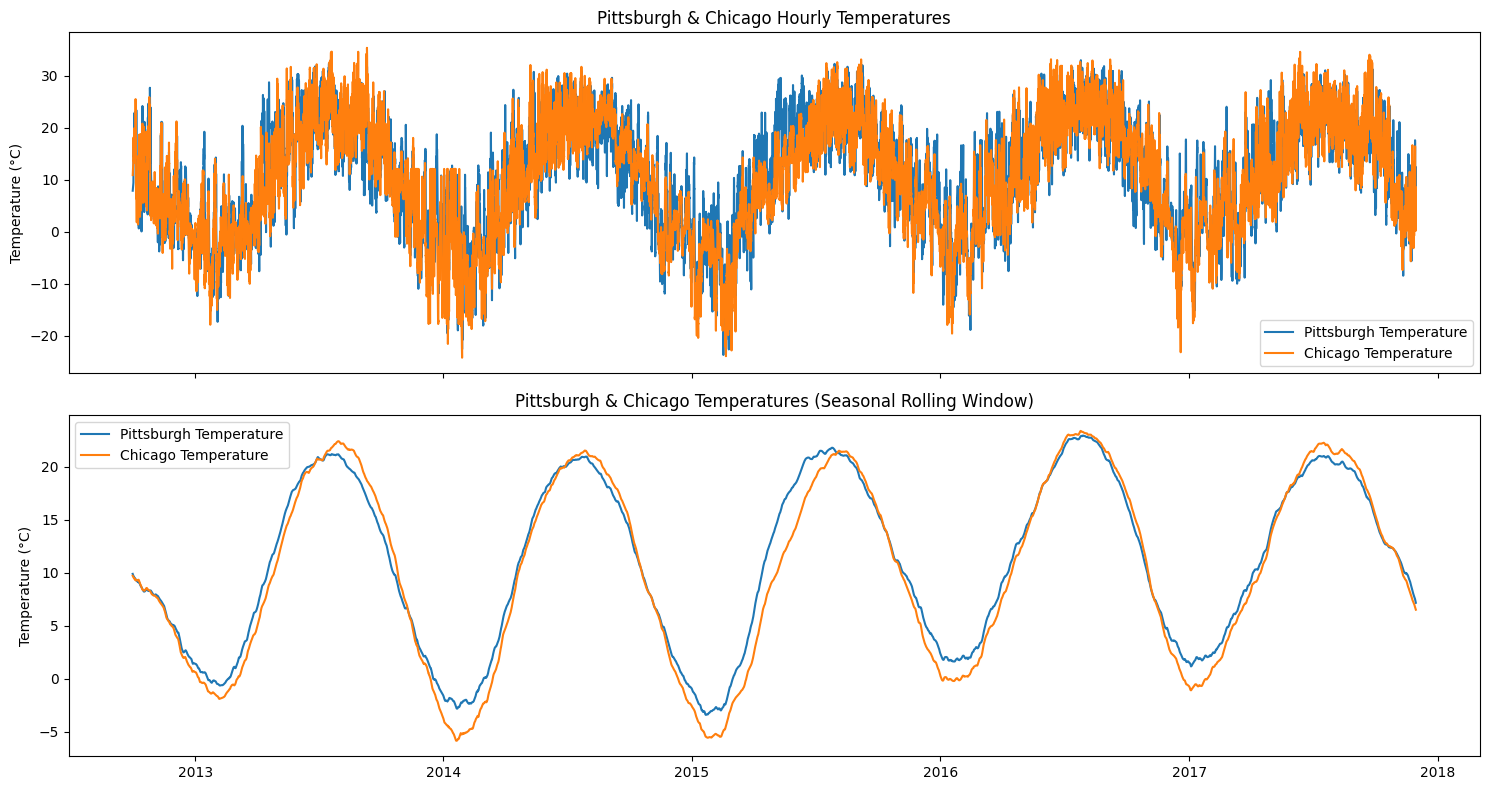

In [25]:
# general season patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# plot raw temperatures
sns.lineplot(data=df_temperature_pittsburgh, x='datetime', y='pittsburgh_temp', label='Pittsburgh Temperature', ax=ax1)
sns.lineplot(data=df_temperature_chicago, x='datetime', y='chicago_temp', label='Chicago Temperature', ax=ax1)
ax1.set_title('Pittsburgh & Chicago Hourly Temperatures')
ax1.set_xlabel('') # redundant
ax1.set_ylabel('Temperature (°C)')

# plot seasonal moving avg
sns.lineplot(data=df_temperature_pittsburgh, x='datetime', y='seasonal_avg', label='Pittsburgh Temperature', ax=ax2)
sns.lineplot(data=df_temperature_chicago, x='datetime', y='seasonal_avg', label='Chicago Temperature', ax=ax2)
ax2.set_title('Pittsburgh & Chicago Temperatures (Seasonal Rolling Window)')
ax2.set_xlabel('') # redundant
ax2.set_ylabel('Temperature (°C)')

# adjust layout and show plot
plt.tight_layout()
plt.show()

By applying a 3-month rolling average, we capture general seasonal trends. We observe that for the time span of our datasets, Chicago's winters are about 2°C colder than Pittsburgh's. Additionally, we notice [the seasonal lag](https://earthsky.org/earth/why-isnt-the-longest-day-of-the-year-the-hottest-day/) of approximately one month. This phase shift is due to thermal inertia, the coldest and hottest days do not occur on the solstices.

Furthermore, this plot allows us to identify broader trends, such as Chicago's 2013 summer being hotter than Pittsburgh's. A more detailed analysis is beyond the scope of this project.

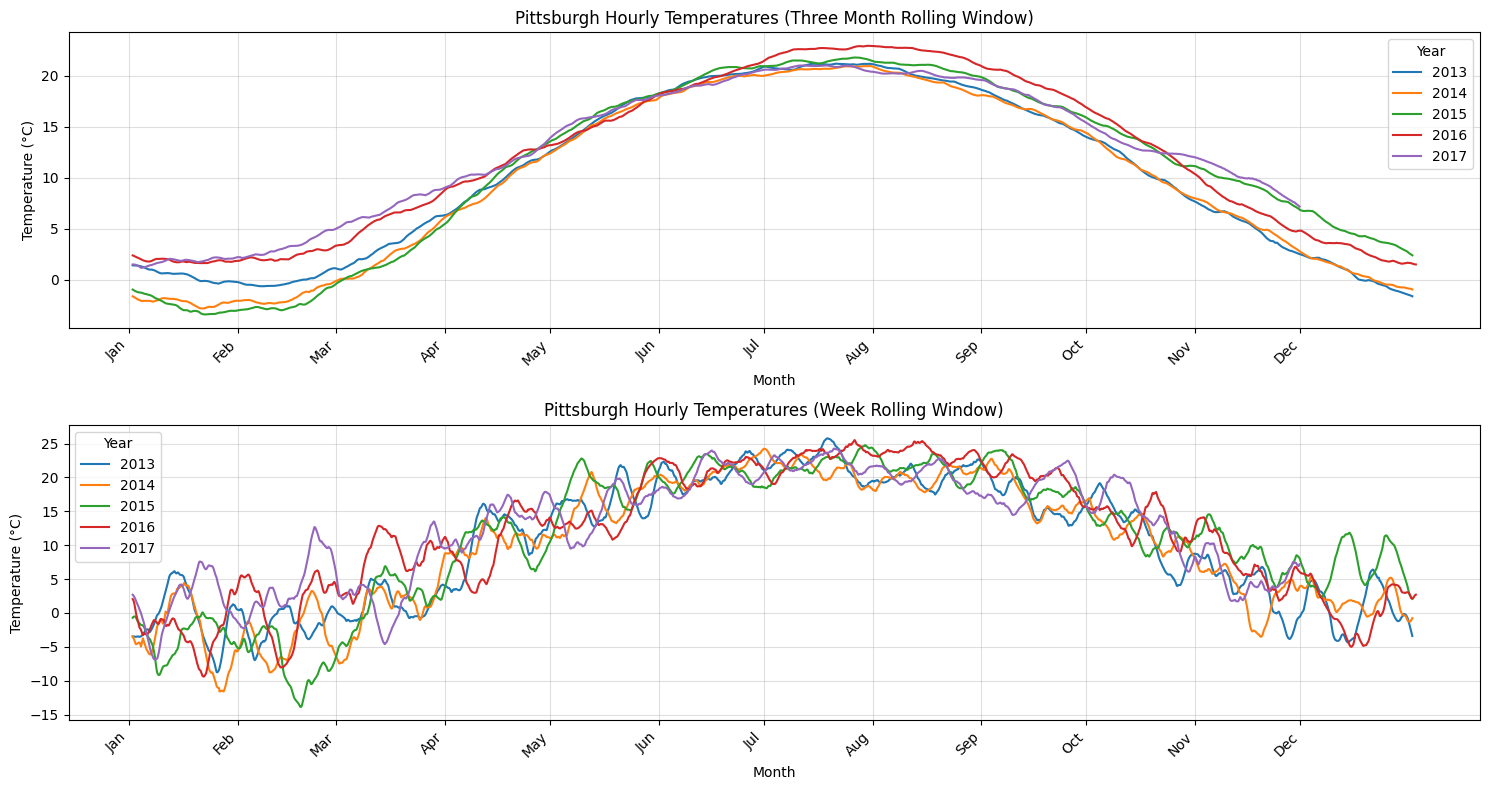

In [26]:
# create 'hour of the year' column to superpose plots
df_temperature_pittsburgh['hour_of_year'] = df_temperature_pittsburgh['day'] * 24 + df_temperature_pittsburgh['hour']

# filter years to plot
years_to_plot = [2013, 2014, 2015, 2016, 2017]

# create a single figure with two subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# plot temp for each year
for year in years_to_plot:
    yearly_data = df_temperature_pittsburgh[df_temperature_pittsburgh['year'] == year]
    sns.lineplot(data=yearly_data, x='hour_of_year', y='seasonal_avg', label=str(year), ax=ax1)
    sns.lineplot(data=yearly_data, x='hour_of_year', y='week_avg', label=str(year), ax=ax2)

# customize the plots
ax1.set_title('Pittsburgh Hourly Temperatures (Three Month Rolling Window)')
ax2.set_title('Pittsburgh Hourly Temperatures (Week Rolling Window)')

for ax in [ax1, ax2]:
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)')
    ax.legend(title='Year')
    ax.grid(True, alpha=0.4)
    
    # set x-ticks to show months
    month_hours = [0, 744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016]
    ax.set_xticks(month_hours)
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# show the plot
plt.tight_layout()
plt.show()

In the plot above, as mentioned previously, a 3-month rolling window is useful for observing seasonal trends; for example, Pittsburgh's 2016 was overall the hottest year in the dataset. However, excessive smoothing does not allow us to observe anomalies in shorter time periods, such as a particularly cold week around the 50th day of 2015 (among other anomalies). We also observe relatively stable temperatures during summer an more instability during winter.

It is left as an exercise for the reader to identify more anomalies in the plot and to repeat the plotting for Chicago. 

The next trend to analyze is the 24-hour cycle. We have already identified the seasonal trend using the 3-month rolling average, so now we can proceed to [deseasonalize](https://coderzcolumn.com/tutorials/data-science/how-to-remove-trend-and-seasonality-from-time-series-data-using-python-pandas) the data. This can be done by subtracting the seasonal trend (3-month rolling average) from the original temperature data. Alternatively, we could apply STL (Seasonal and Trend decomposition using Loess).

In [27]:
# restore 'datetime' column
df_temperature_pittsburgh.reset_index(drop=False, inplace=True)

In [28]:
# subtract the centered rolling average
df_temperature_pittsburgh['temp_deseason'] = df_temperature_pittsburgh['pittsburgh_temp'] - df_temperature_pittsburgh['seasonal_avg']

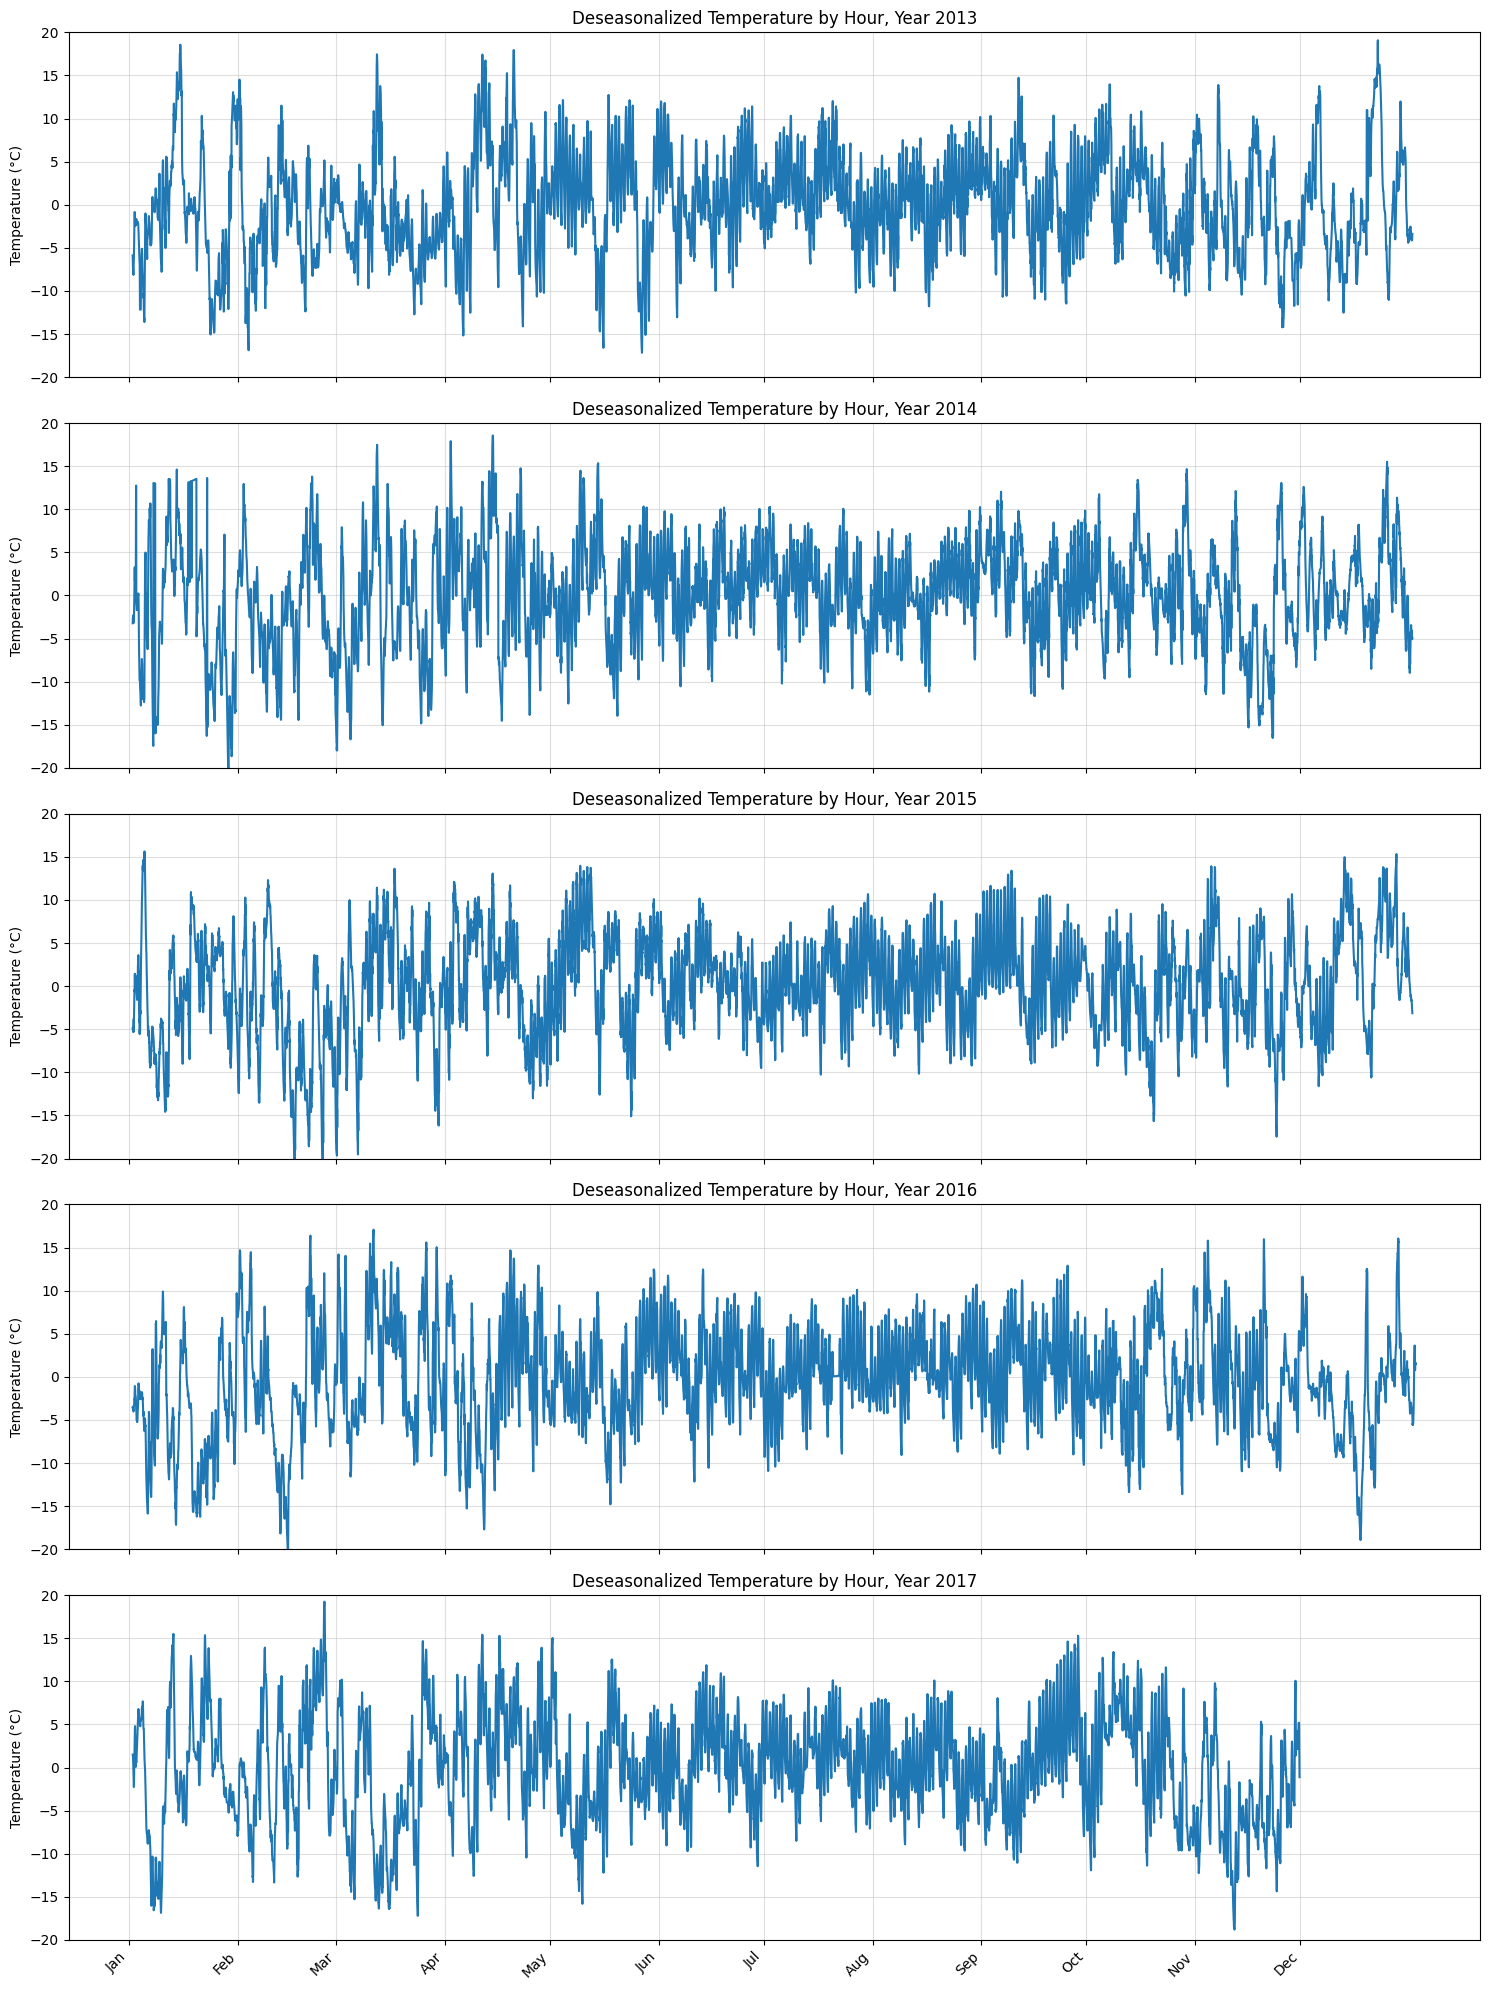

In [29]:
# create a figure with 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

# plot temp for each year in separate subplots
for idx, year in enumerate(years_to_plot):
    yearly_data = df_temperature_pittsburgh[df_temperature_pittsburgh['year'] == year]
    sns.lineplot(data=yearly_data, x='hour_of_year', y='temp_deseason', ax=axes[idx])
    axes[idx].set_title(f'Deseasonalized Temperature by Hour, Year {year}')
    axes[idx].set_ylabel('Temperature (°C)')
    axes[idx].set_xlabel('')
    axes[idx].set_ylim(-20, 20)
    axes[idx].grid(True, alpha=0.4)

# set x-ticks to show months
month_hours = [0, 744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016]
axes[-1].set_xticks(month_hours)
axes[-1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

That is a **lot** of noise, specially during the cold season. The termal amplitude has a big range of variation day by day; which drives us to the other plot below:

In [30]:
# create season column
df_temperature_pittsburgh['season'] = df_temperature_pittsburgh['datetime'].dt.month.apply(
    lambda x:
        'winter' if x in [12, 1, 2]
        else 'spring' if x in [3, 4, 5]
        else 'summer' if x in [6, 7, 8]
        else 'fall'
)

# group by season and hour
df_temperature_pittsburgh_day = df_temperature_pittsburgh.groupby(['season', 'hour']).agg(
    temp_avg=('temp_deseason', 'mean'),
    temp_min=('temp_deseason', 'min'),
    temp_max=('temp_deseason', 'max'),
    cold_hours=('pittsburgh_cold', 'sum'),
    hot_hours=('pittsburgh_hot', 'sum')
).reset_index()

df_temperature_pittsburgh_day.head()

season  hour  temp_avg   temp_min   temp_max  cold_hours  hot_hours
0   fall     0 -1.654938 -17.660650  13.143398         242          1
1   fall     1 -2.069636 -17.814860  12.457596         250          0
2   fall     2 -2.434430 -18.489945  12.291789         256          0
3   fall     3 -2.782892 -18.557324  10.199864         263          0
4   fall     4 -3.061788 -18.640318   9.907772         274          0

Now 

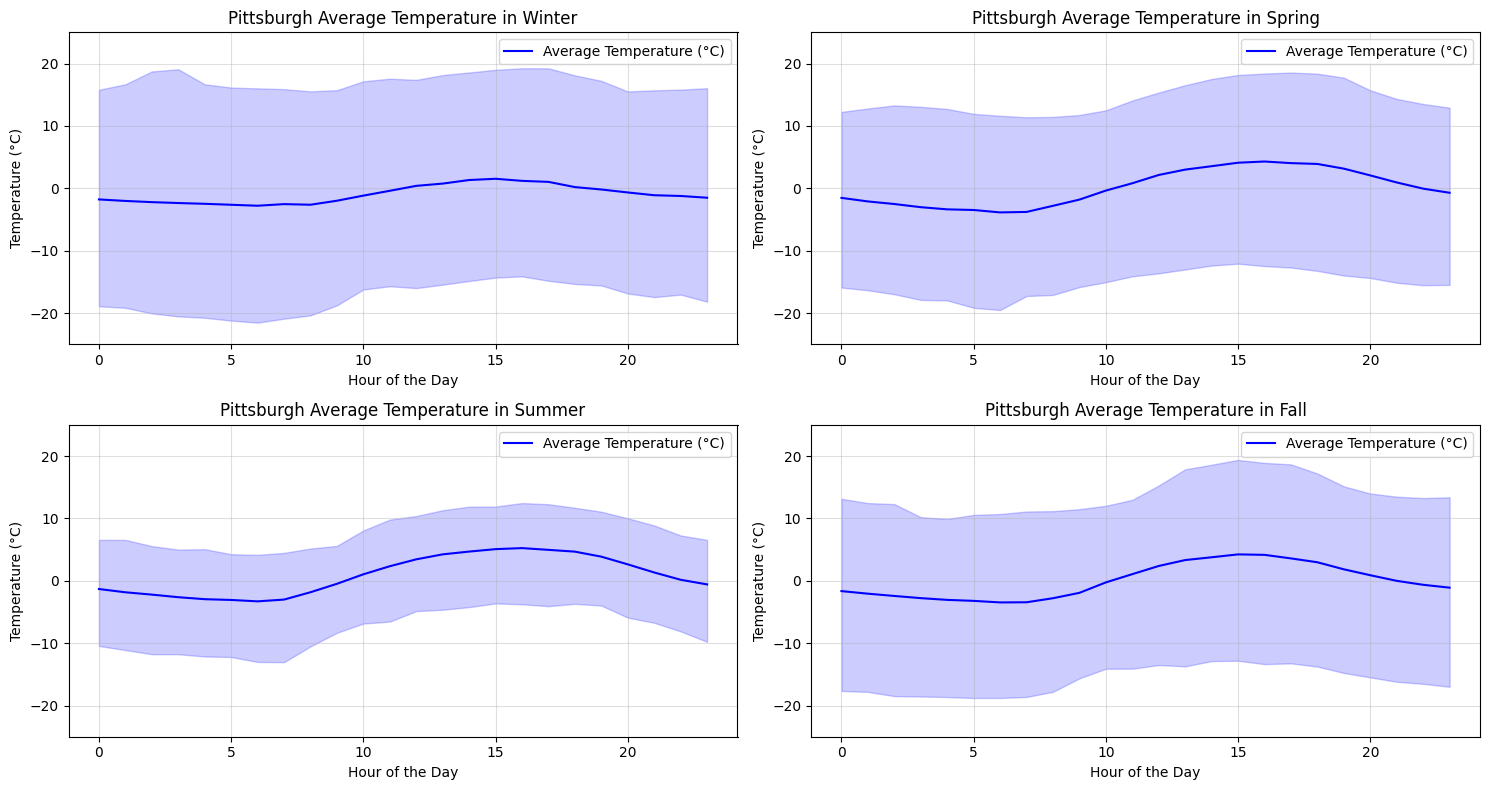

In [31]:
# define the seasons for iteration
seasons = ['winter', 'spring', 'summer', 'fall']

# create a 2x2 grid for plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
axes = axes.flatten()  # flatten the 2D array of axes to make it easier to iterate

# Loop through each season and plot
for i, season in enumerate(seasons):
    # filter data for the current season
    season_data = df_temperature_pittsburgh_day[df_temperature_pittsburgh_day['season'] == season]
    
    # create line plot for average temperature
    sns.lineplot(data=season_data, x='hour', y='temp_avg', ax=axes[i], label='Average Temperature (°C)', color='blue')
    
    # fill between min and max temperatures
    axes[i].fill_between(season_data['hour'], 
                         season_data['temp_min'], 
                         season_data['temp_max'], 
                         alpha=0.2, color='blue')
    
    # Set titles and labels
    axes[i].set_title(f'Pittsburgh Average Temperature in {season.capitalize()}')
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Temperature (°C)')
    axes[i].grid(True, alpha=0.4)
    axes[i].set_ylim(-25, 25) # unify scale

# Adjust layout
plt.tight_layout()
plt.show()

As we see above, the hourly temperature by day has a lot of variation. Still we can apreciate a minimum around 6:30 and a maximum around 15:00 ([as in any part of the world](https://www.thoughtco.com/high-and-low-temperature-timing-3444247)). Not great, not terrible.

We still need to prove a 24 hs cycle:

In [32]:
# calculate 'hour_of_the_month'
df_temperature_pittsburgh['hour_of_the_month'] = df_temperature_pittsburgh['datetime'].dt.day * 24 + df_temperature_pittsburgh['hour'] - 24

df_temperature_pittsburgh['hour_of_the_month'].describe()


count    45253.000000
mean       364.816167
std        211.186639
min          0.000000
25%        182.000000
50%        365.000000
75%        547.000000
max        743.000000
Name: hour_of_the_month, dtype: float64

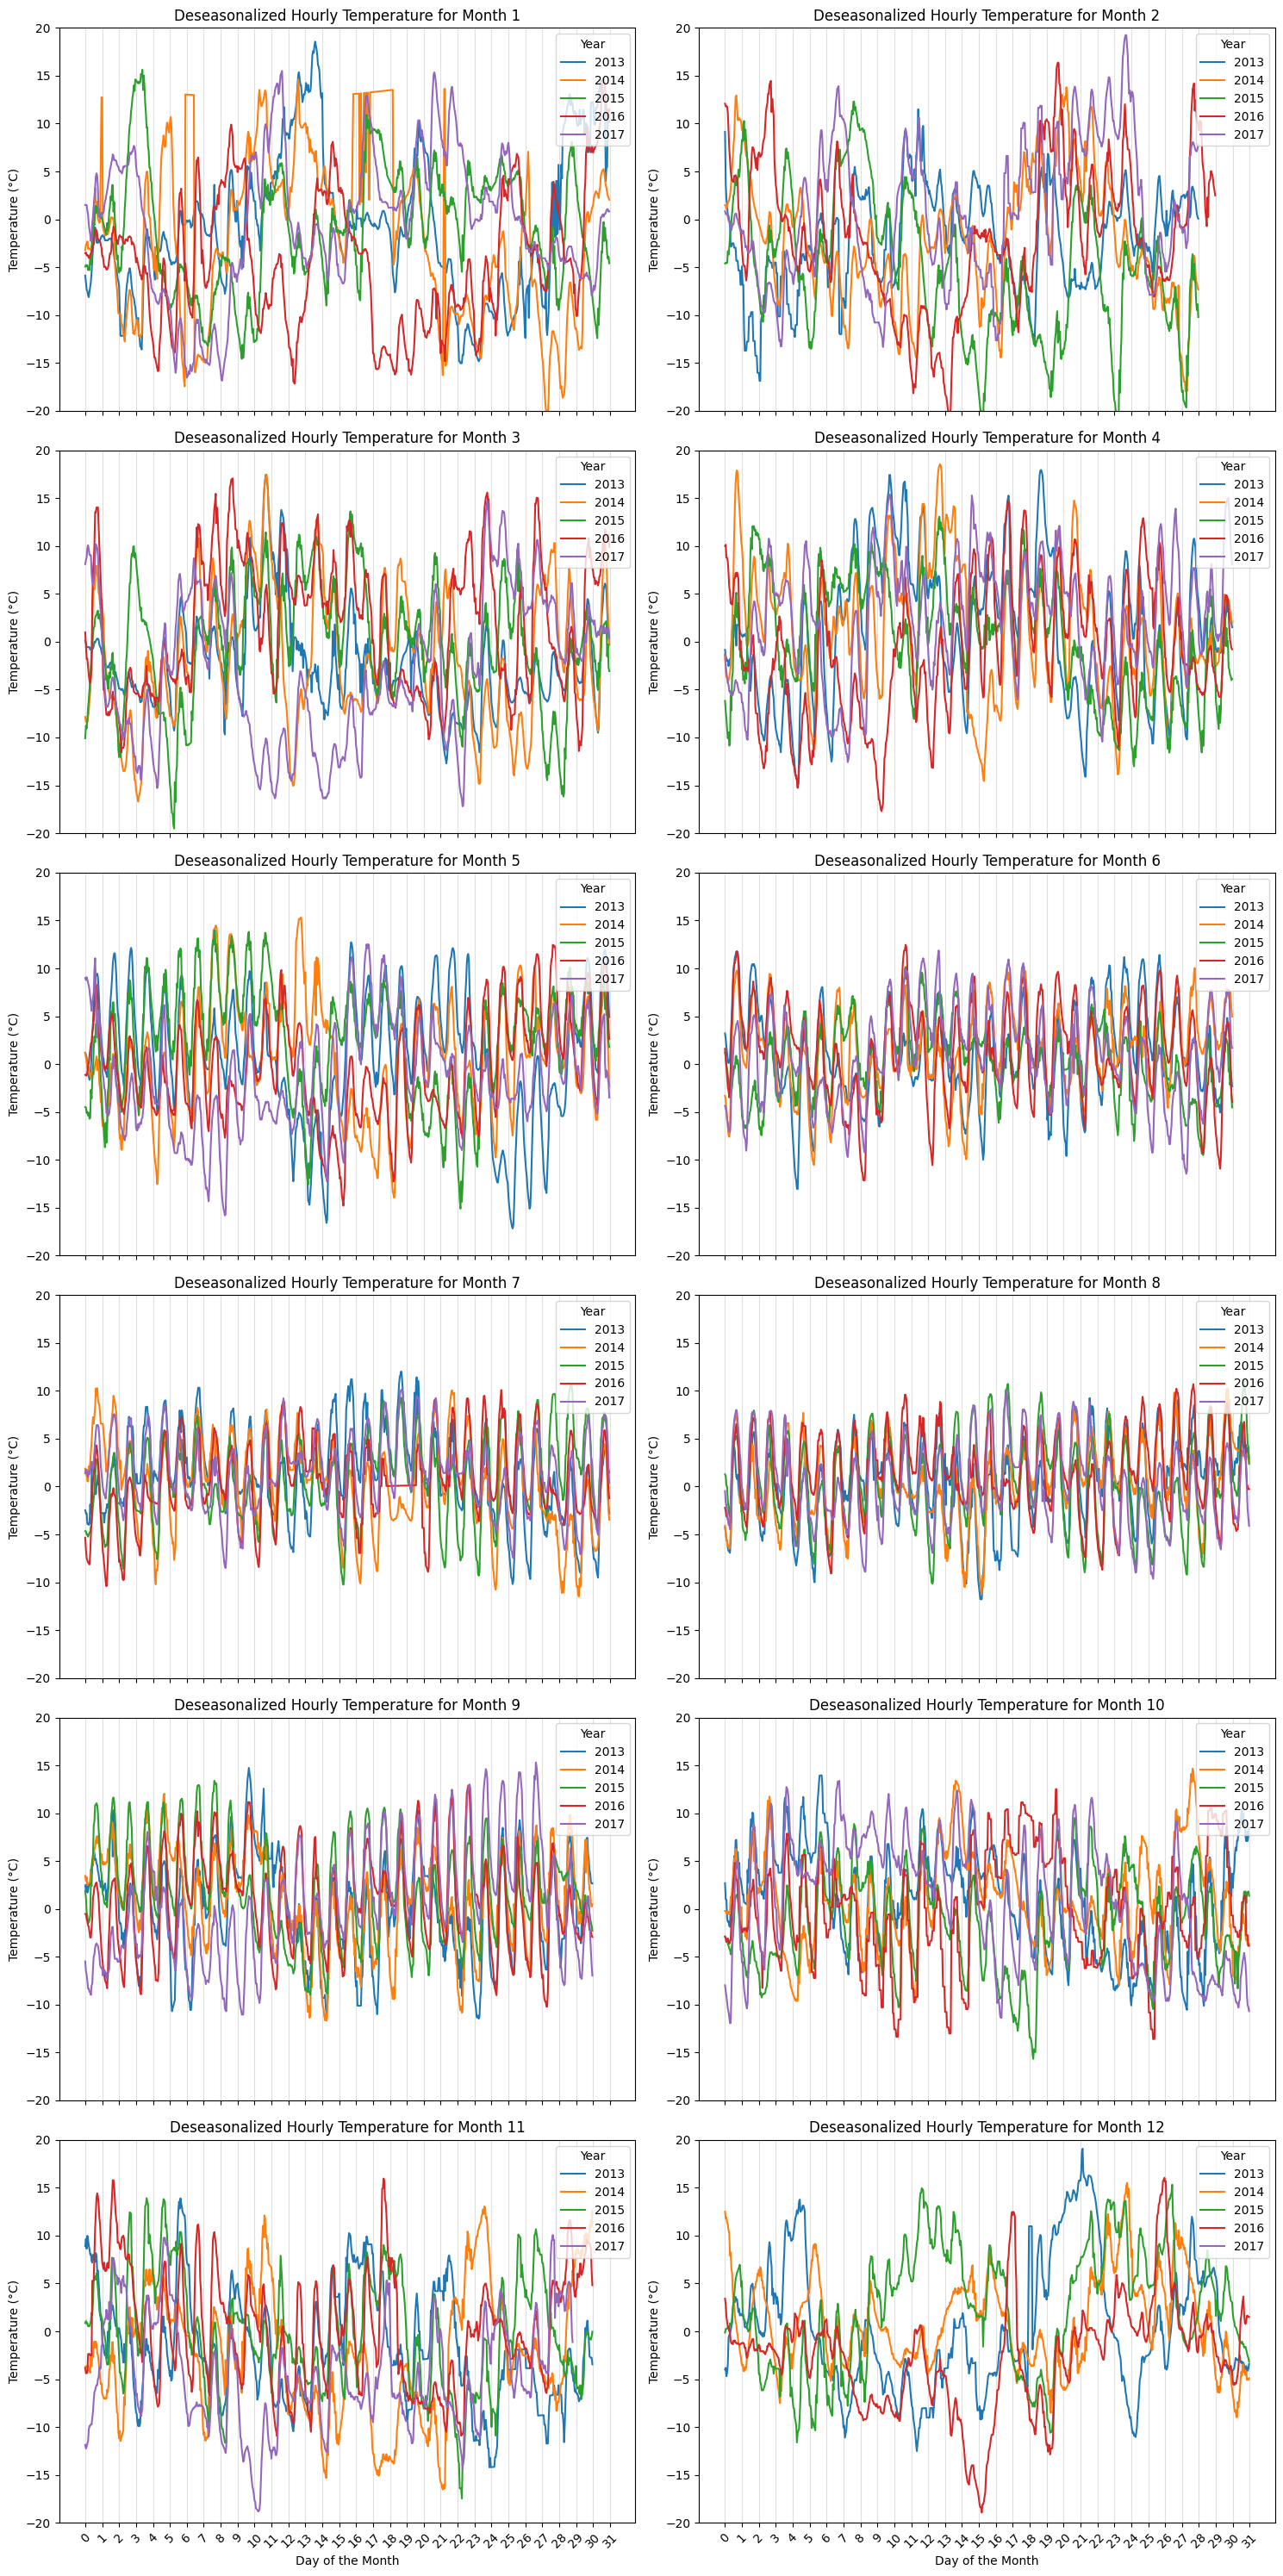

In [33]:
# filter years to plot
years_to_plot = [2013, 2014, 2015, 2016, 2017]

# create a figure with 12 subplots (one for each month)
fig, axes = plt.subplots(6, 2, figsize=(15, 30), sharex=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# plot temp for each month
for month in range(1, 13):  # months from january (1) to december (12)
    for year in years_to_plot:
        yearly_data = df_temperature_pittsburgh[(df_temperature_pittsburgh['year'] == year) & 
                                                (df_temperature_pittsburgh['month'] == month)]
        sns.lineplot(data=yearly_data, x='hour_of_the_month', y='temp_deseason', label=str(year), ax=axes[month-1])

    # customize each subplot
    axes[month-1].set_title(f'Deseasonalized Hourly Temperature for Month {month}')
    axes[month-1].set_ylabel('Temperature (°C)')
    axes[month-1].set(xlabel='Day of the Month')
    axes[month-1].set_ylim(-20, 20) # unify scale
    axes[month-1].grid(axis='x', alpha=0.4)
    axes[month-1].legend(title='Year', loc='upper right')
    axes[month-1].xaxis.set_tick_params(rotation=45) # rotate x-tick labels

# define the number of days in the month
days_in_month = 31

# create hour ticks from 0 to 24*31 (744)
hour_ticks = [i * 24 for i in range(days_in_month + 1)]  # +1 to include the last tick at hour 744

# create labels for each day
day_labels = [str(i) for i in range(0, days_in_month + 1)]  # labels from '0' to '31'

# set the x-ticks and x-tick labels on all axes
for ax in axes:
    ax.set_xticks(hour_ticks)
    ax.set_xticklabels(day_labels)

# # rotate the labels
# plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# # set a common x-label for all subplots
# plt.xlabel('Hour of the Month')

plt.tight_layout()
plt.show()

In the plots above, despite the significant noise, we can clearly observe a 24-hour cycle in the temperature. This pattern is particularly evident from May to September.

For temperature we can distinguish between two distinct frequencies: the 3-month seasonal cycle, which reflects longer-term temperature trends, and the 24-hour daily cycle, which captures the diurnal variation in temperature. 

Additionally we can perform Fast Fourier Transform (FFT) as a verification:

In [34]:
# extract temperature data into numpy array
temperature_data = df_temperature_pittsburgh['pittsburgh_temp'].values

# verify there are no missing values
missing_values = np.isnan(temperature_data).sum()
print(f'## missing values in temperature_data to be removed: {missing_values}')

# remove missing values
temperature_data = temperature_data[~np.isnan(temperature_data)]

# use numpy fft function to compute the fft of the temperature data
fft_result = np.fft.fft(temperature_data)

# calculate the frequencies of the fft result
sample_rate = 1 # 1 hour sampling rate
n = len(temperature_data) # number of samples
frequencies = np.fft.fftfreq(n, d=1/sample_rate)

## missing values in temperature_data to be removed: 3


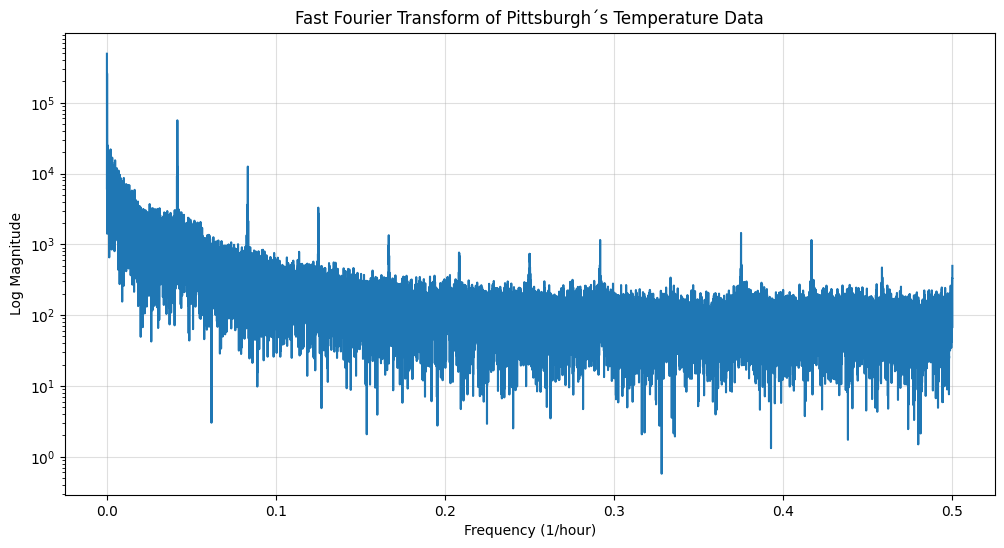

In [35]:
# plot the result
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:n // 2], np.abs(fft_result)[:n // 2]) # plot only positive freqs
plt.title('Fast Fourier Transform of Pittsburgh´s Temperature Data')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Log Magnitude')
plt.yscale('log')
plt.grid(True, alpha=0.4)
plt.show()

Each peak is separated by multiples of a fundamental frequency $f_0 = 0.0416667 \, \mathrm{· 1/hour}$. That is, the harmonics are given by $f_n = n \times f_0$. By inverting $f_0$, we obtain the time period: $1/f_0 = 24 \, \mathrm{hour}$.

In simpler terms, by applying FFT, we identified the 24-hour cycle. Notice the FFT captured only the daily cycle.

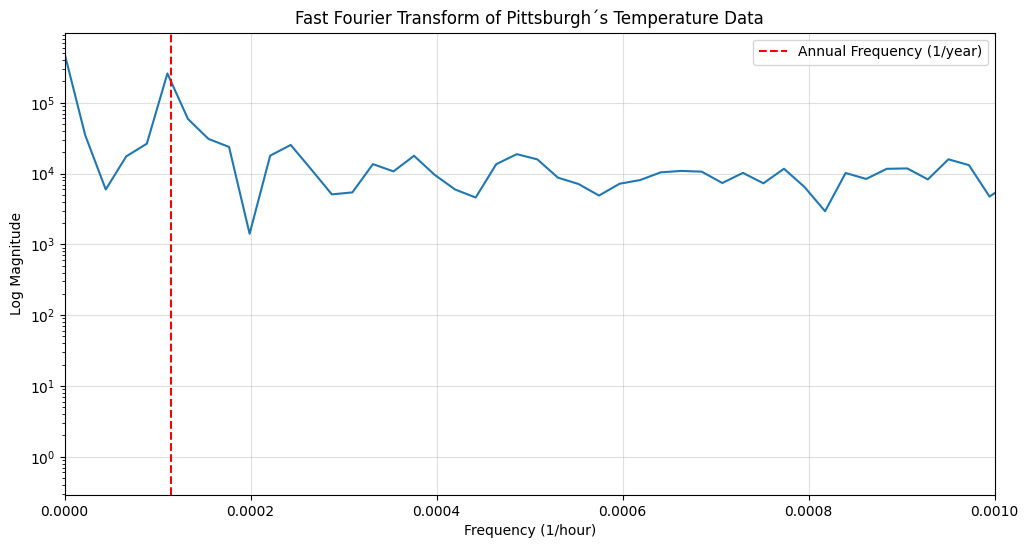

In [36]:
# plot the result
plt.figure(figsize=(12, 6))
plt.plot(frequencies[:n // 2], np.abs(fft_result)[:n // 2]) # plot only positive freqs
plt.title('Fast Fourier Transform of Pittsburgh´s Temperature Data')
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Log Magnitude')
plt.xlim(0, 0.001)
plt.yscale('log')
plt.grid(True, alpha=0.4)

# add a vertical dashed line at x = 0.000114077116131, which is 1/(hours in a year)
plt.axvline(x=0.000114077116131, color='red', linestyle='--', label='Annual Frequency (1/year)')
plt.legend()

plt.show()

The resolution for the yearly cycle is not the best, and due the scale diference (two magnitude orders) a scale change is needed in order to find it. It remains as an exercise for the reader to repeat the Fourier Transform on the 3-month rolling average and identify the cycle´s period.

### Energy Load

The energy load of an electrical network depends primarily on human activity. It is influenced by the circadian cycle, the workweek cycle, and temperature variations —this last factor being more pronounced in developed countries.

As mentioned earlier, we can speculate that the temperature in the energy distribution zone is similar to that of the main cities. Conversely, we can also speculate that the energy load of the main cities will be proportional to the overall load of the distribution zone. Even more, we can speculate the normalized load by user is the same all around the cities in the electrical network zone.

In [37]:
# isolate the data
df_energy_pittsburgh = df_energy[['datetime', 'pittsburgh_temp', 'Duquesne_kW', 'is_NWD']].copy()

# set datetime as index
df_energy_pittsburgh.set_index('datetime', inplace=True)

# calculate seasonal average (3 month span) WITH A CENTERED ROLLING WINDOW
df_energy_pittsburgh['T_seasonal_avg'] = df_energy_pittsburgh['pittsburgh_temp'].rolling(window='30D', center=True).mean()
df_energy_pittsburgh['E_seasonal_avg'] = df_energy_pittsburgh['Duquesne_kW'].rolling(window='30D', center=True).mean()

# restore 'datetime' column
df_energy_pittsburgh.reset_index(drop=False, inplace=True)

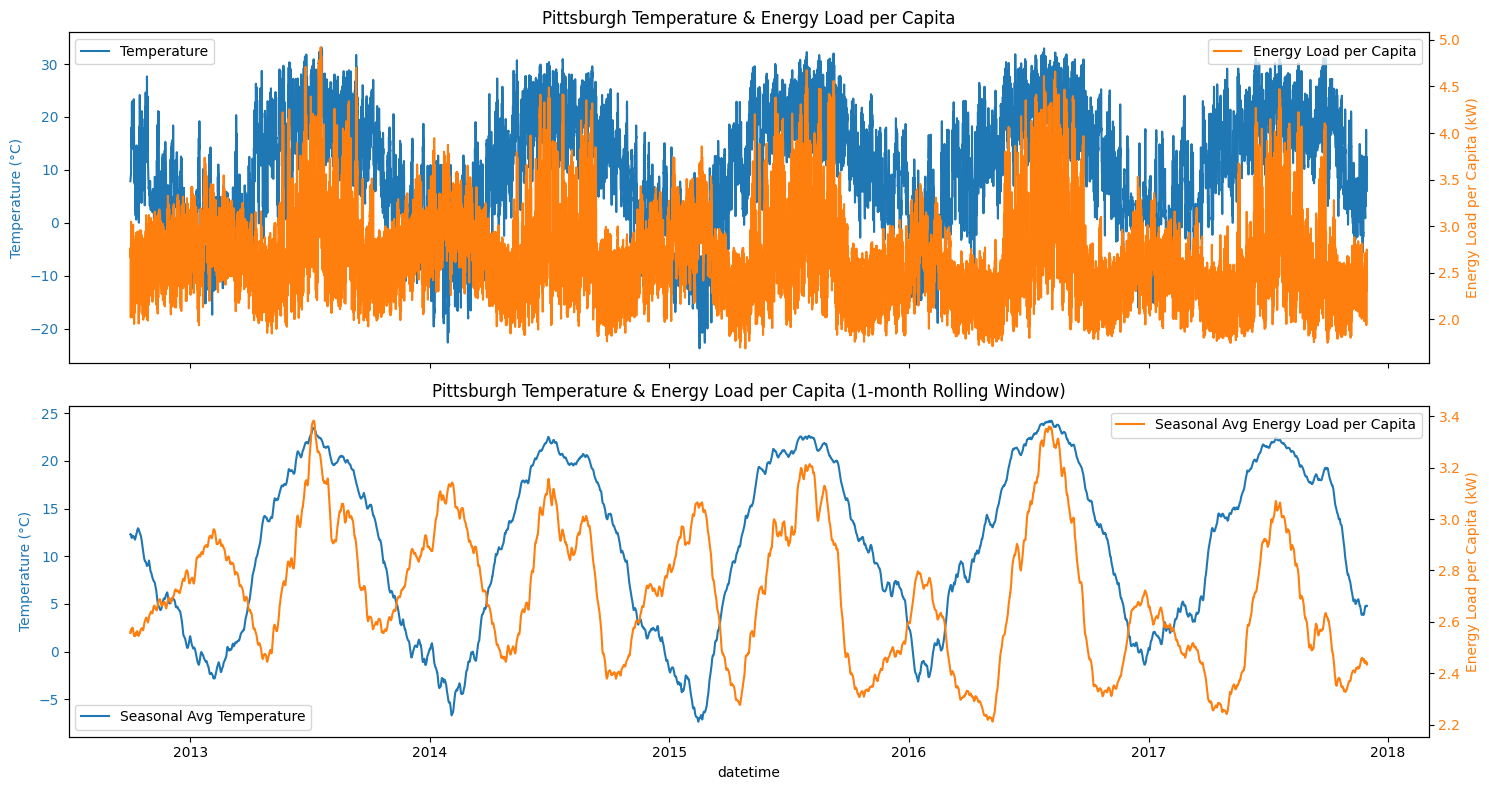

In [38]:
# general seasonal patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# plot raw temperatures and energy load on the first axis
sns.lineplot(data=df_energy_pittsburgh, x='datetime', y='pittsburgh_temp', label='Temperature', ax=ax1, color='#1f77b4')
ax1.set_ylabel('Temperature (°C)', color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# create a second y-axis for energy load on the same plot
ax1_energy = ax1.twinx()
sns.lineplot(data=df_energy_pittsburgh, x='datetime', y='Duquesne_kW', label='Energy Load per Capita', ax=ax1_energy, color='#ff7f0e')
ax1_energy.set_ylabel('Energy Load per Capita (kW)', color='#ff7f0e')
ax1_energy.tick_params(axis='y', labelcolor='#ff7f0e')

# set title for the first subplot
ax1.set_title('Pittsburgh Temperature & Energy Load per Capita')

# plot seasonal moving averages on the second axis
sns.lineplot(data=df_energy_pittsburgh, x='datetime', y='T_seasonal_avg', label='Seasonal Avg Temperature', ax=ax2, color='#1f77b4')
ax2.set_ylabel('Temperature (°C)', color='#1f77b4')
ax2.tick_params(axis='y', labelcolor='#1f77b4')

# create a second y-axis for seasonal energy load on the same plot
ax2_energy = ax2.twinx()
sns.lineplot(data=df_energy_pittsburgh, x='datetime', y='E_seasonal_avg', label='Seasonal Avg Energy Load per Capita', ax=ax2_energy, color='#ff7f0e')
ax2_energy.set_ylabel('Energy Load per Capita (kW)', color='#ff7f0e')
ax2_energy.tick_params(axis='y', labelcolor='#ff7f0e')

# set title for the second subplot
ax2.set_title('Pittsburgh Temperature & Energy Load per Capita (1-month Rolling Window)')

# adjust layout and show plot
plt.tight_layout()
plt.show()


This is a complicated cyclical behavior that we observe in the energy load. Without the temperature plot, it's easy to assume a half-year cycle when, in reality, we are dealing with a bimodal (hot season - cold season) yearly cycle.

In general, we can observe a remarkable correlation between temperature and energy load: every peak in temperature corresponds to a peak in energy consumption.

In [39]:
# first we remove unnecessary columns to clean a little
df_energy_pittsburgh.drop(columns=['T_seasonal_avg', 'E_seasonal_avg'], inplace=True)

In [40]:
# create column for hour of the day
df_energy_pittsburgh['hour_of_day'] = df_energy_pittsburgh['datetime'].dt.hour

# create a column for hour of the week
df_energy_pittsburgh['hour_of_week'] = df_energy_pittsburgh['datetime'].dt.dayofweek * 24 + df_energy_pittsburgh['hour_of_day']

# create a column for month
df_energy_pittsburgh['month'] = df_energy_pittsburgh['datetime'].dt.month

df_energy_pittsburgh.head()

datetime  pittsburgh_temp  Duquesne_kW  is_NWD  \
0 2012-10-01 08:00:00-04:00              NaN     2.716667       0   
1 2012-10-01 09:00:00-04:00         7.850000     2.733333       0   
2 2012-10-01 10:00:00-04:00         7.874767     2.745000       0   
3 2012-10-01 11:00:00-04:00         7.938319     2.716667       0   
4 2012-10-01 12:00:00-04:00         8.001870     2.711667       0   

   hour_of_day  hour_of_week  month  
0            8             8     10  
1            9             9     10  
2           10            10     10  
3           11            11     10  
4           12            12     10

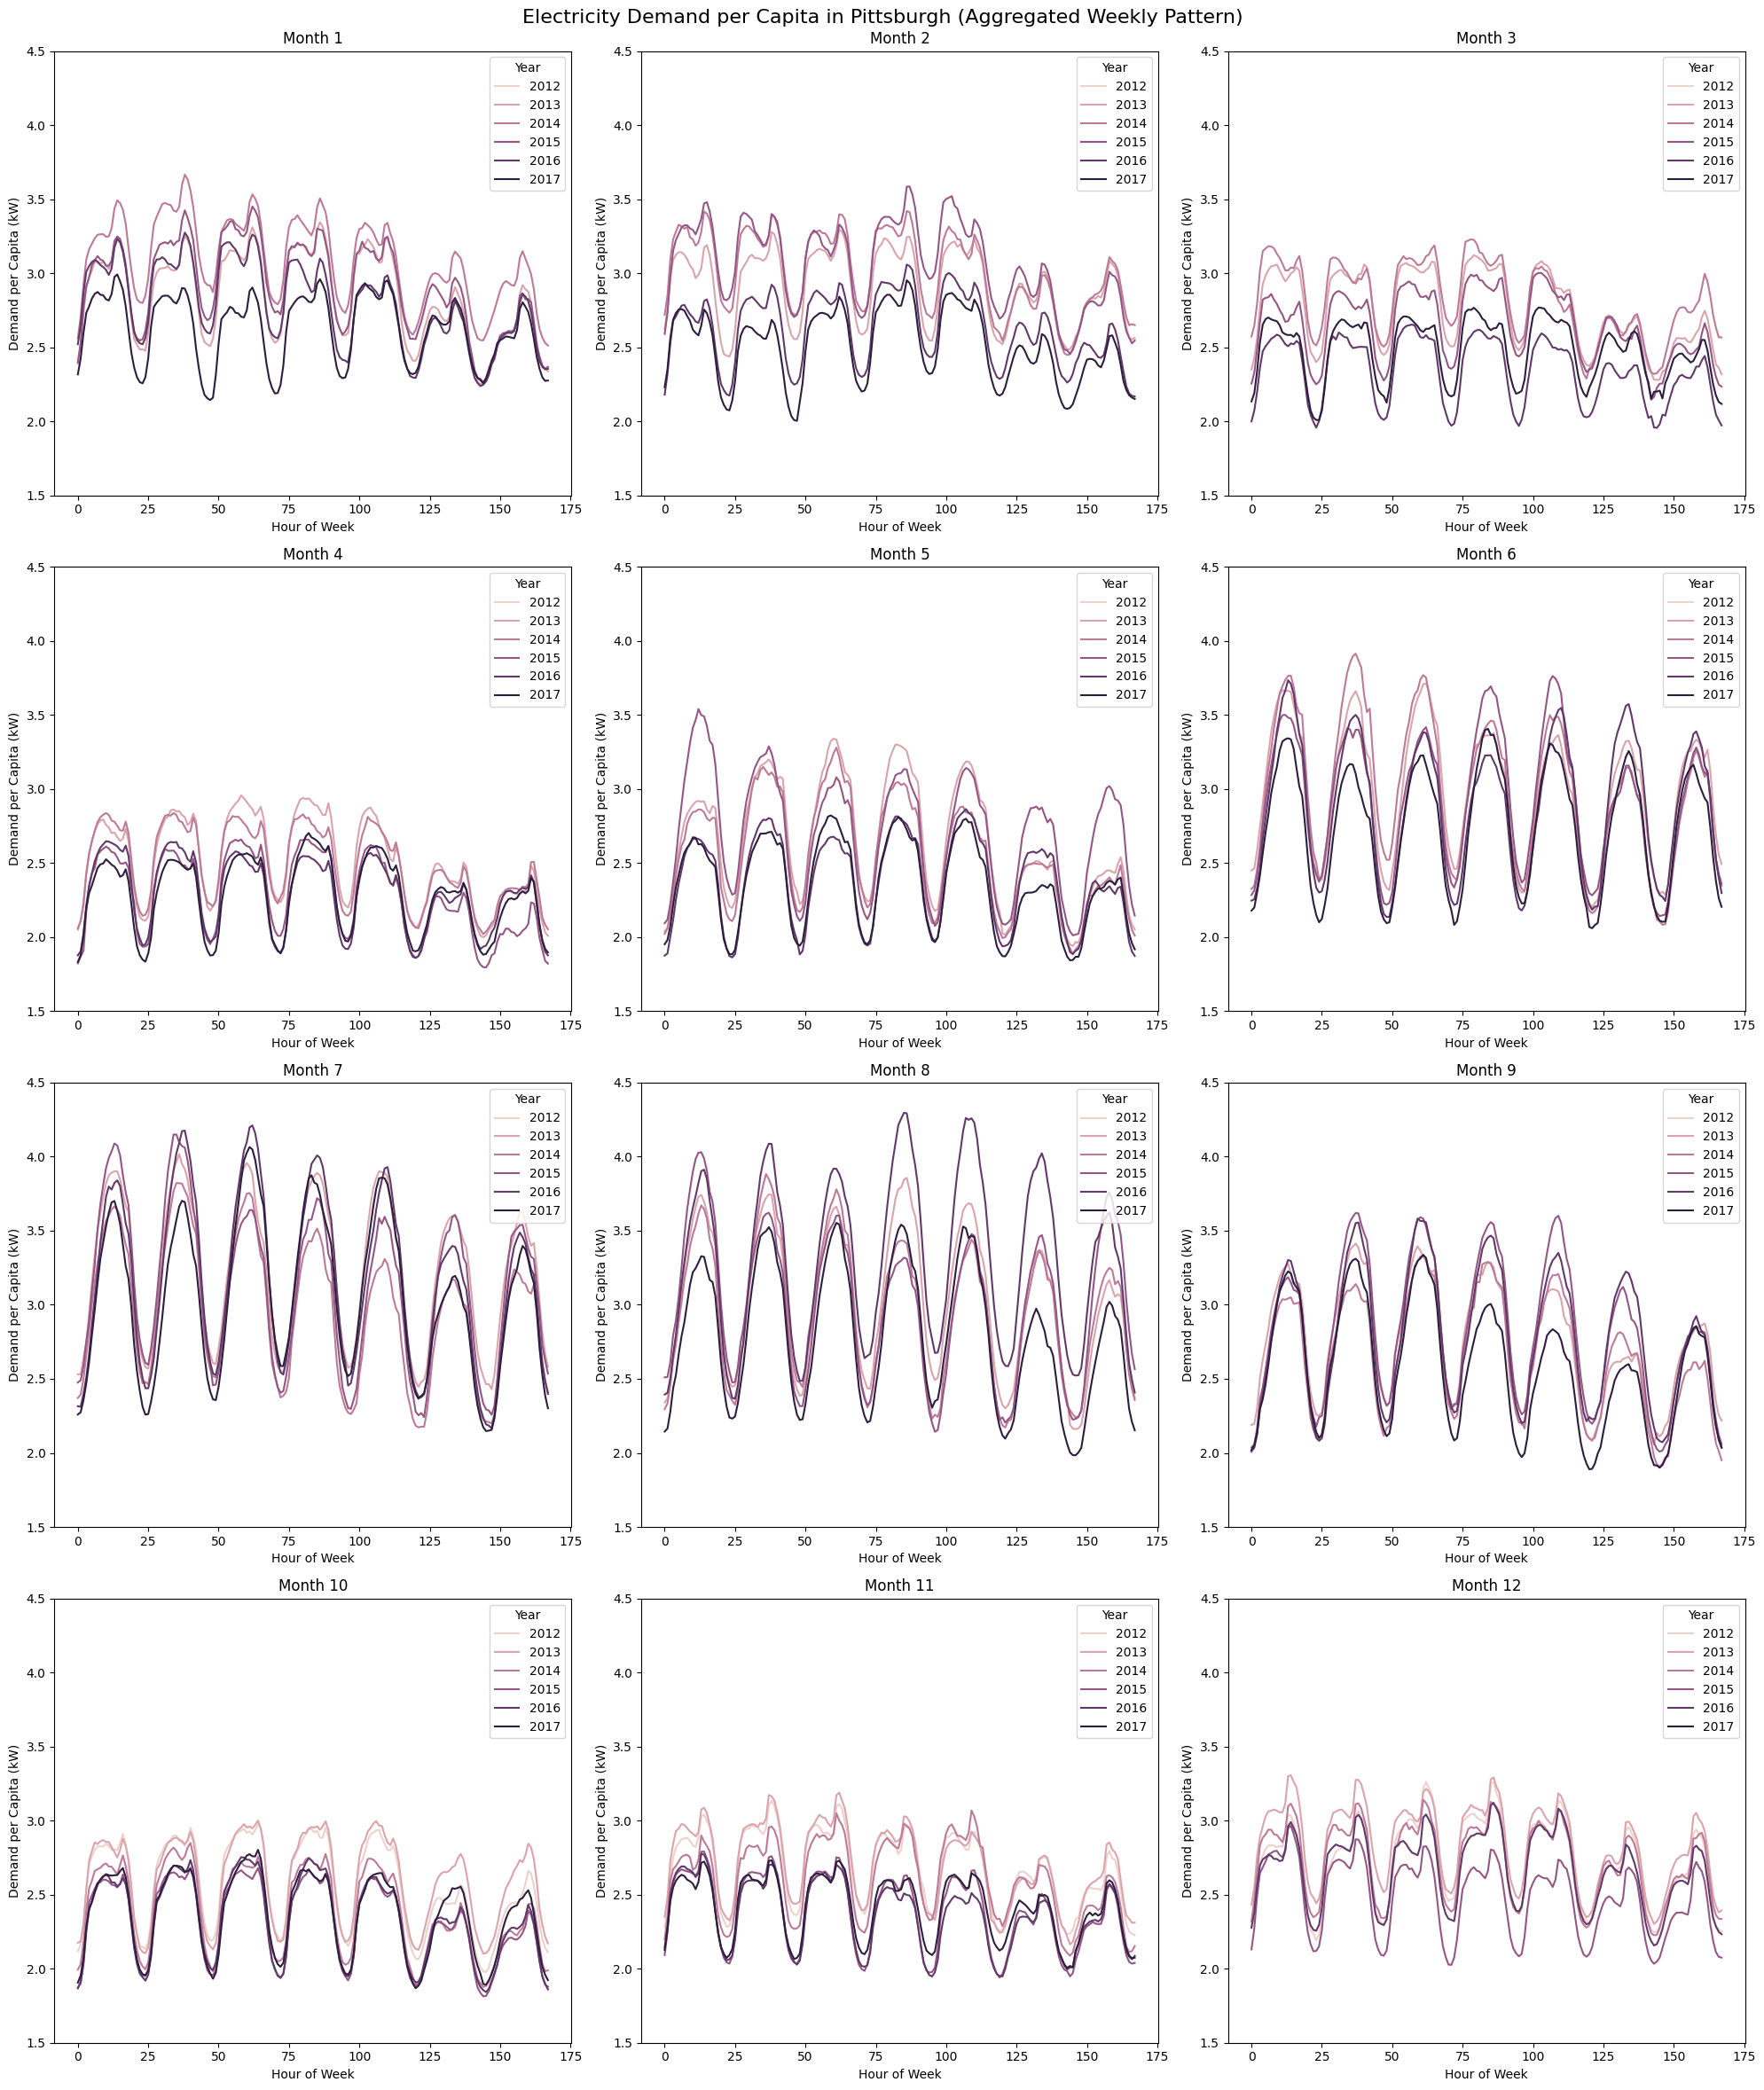

In [41]:
# create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 24))
fig.suptitle('Electricity Demand per Capita in Pittsburgh (Aggregated Weekly Pattern)\n', fontsize=16)

# flatten the axes array for easier iteration
axes = axes.flatten()

# plot energy load per capita for each month
for i, ax in enumerate(axes, start=1):
    sns.lineplot(
        data=df_energy_pittsburgh[df_energy_pittsburgh['datetime'].dt.month == i],
        x='hour_of_week',
        y='Duquesne_kW',
        hue=df_energy_pittsburgh['datetime'].dt.year,
        errorbar=None,
        linewidth=1.5,
        ax=ax
    )

    # customize each subplot
    ax.set_title(f'Month {i}')
    ax.set_xlabel('Hour of Week')
    ax.set_ylabel('Demand per Capita (kW)')
    ax.set_ylim(1.5, 4.5) # unify scale
    ax.legend(title='Year', loc='upper right')

# adjust layout and show the plot
plt.tight_layout()
plt.show()

In the plot above, we can see the aggregated weekly pattern of energy consumption in Pennsylvania per capita, which we assumed is the same for Pittsburgh. The multiple minima-maxima observed pattern represent the night-day cycle of each day (circadian rhythm). The two last peaks on each week are lower due to the reduced electricity consumption on weekends.

The complexity of the energy load cycle necessitates feature engineering for its deseasonalization or other techniques like [filtering and autocorrelation](https://www.kaggle.com/code/selfishgene/filtering-and-auto-correlation-tutorial), or [Multiple-Seasonal-Trend decomposition using Loess (MSTL)](https://www.blog.trainindata.com/multi-seasonal-time-series-decomposition-using-mstl-in-python/). MSTL assumes that the time series can be expressed as an additive decomposition:

$$y_t = \hat{T} + \hat{S}^{(1)}_{t} + \hat{S}^{(2)}_{t} + ...  + \hat{S}^{(N)}_{t} + \hat{R}_{t}$$

Where $\hat{T}$ is the trend component, $\hat{S}^{(i)}_{t}$ is the i-th seasonal component, and $\hat{R}_{t}$ is the residual component.

In the case of energy load, we have a 1-year seasonal component due to the stations and people turning on the heating or air conditioners. There is a 1-week seasonal component due to lower energy consumption on weekends. Additionally, there is a 24-hour seasonal component due to the circadian cycle.

In order to apply MSTL we need first to **impute missing data**. Then, if the time series is **not** described by an additive decomposition, we need to apply a **Box Cox transform** to convert it into an additive decomposition.

In [42]:
# search for missing values
print(f'## The missing values in df_energy_pittsburgh are:\n\n{df_energy_pittsburgh.isna().sum()}')

## The missing values in df_energy_pittsburgh are:

datetime           0
pittsburgh_temp    3
Duquesne_kW        0
is_NWD             0
hour_of_day        0
hour_of_week       0
month              0
dtype: int64


Without missing values in the energy load per capita, we can proceed to apply MSTL. Its most mportant parameters are:

- **periods**: the period of each seasonal component, period, passed to STL (e.g., for hourly data with daily and weekly seasonality we set periods = (24, 24*7));
- **windows**: the seasonal window sizes, seasonal, passed to STL for each respective seasonal component (e.g., windows = (11, 15)). MSTL uses default values based on experiments which gave the best results;
- **seasonal_deg**: the degree of the polynomial for the seasonal component, by default seasonal_deg = 0;
- **lmbda**: if a Box Cox transform is required then we need to pick a value for the λ parameter of a Box Cox transform. λ can be set manually, lmbda=0.7 , or automatically, lmbda="auto" .

In [43]:
# set (again) datetime as index
df_energy_pittsburgh.set_index('datetime', inplace=True)

In [44]:
# instantitate the model
mstl = MSTL(df_energy_pittsburgh['Duquesne_kW'], periods=[24, 24*7, 24*365], stl_kwargs={'seasonal_deg':0})
result = mstl.fit()

In [45]:
# inspect trend
result.trend.head()

datetime
2012-10-01 08:00:00-04:00    2.807204
2012-10-01 09:00:00-04:00    2.807206
2012-10-01 10:00:00-04:00    2.807207
2012-10-01 11:00:00-04:00    2.807209
2012-10-01 12:00:00-04:00    2.807210
Name: trend, dtype: float64

In [46]:
# inspect seasonal results
result.seasonal.head()

seasonal_24  seasonal_168  seasonal_8760
datetime                                                           
2012-10-01 08:00:00-04:00     0.221980      0.073038      -0.382984
2012-10-01 09:00:00-04:00     0.240095      0.062681      -0.372894
2012-10-01 10:00:00-04:00     0.251760      0.065843      -0.374739
2012-10-01 11:00:00-04:00     0.260961      0.062041      -0.360898
2012-10-01 12:00:00-04:00     0.230229      0.073878      -0.342947

In [47]:
# inspect residue
result.resid.head()

datetime
2012-10-01 08:00:00-04:00   -0.002572
2012-10-01 09:00:00-04:00   -0.003754
2012-10-01 10:00:00-04:00   -0.005071
2012-10-01 11:00:00-04:00   -0.052646
2012-10-01 12:00:00-04:00   -0.056704
Name: resid, dtype: float64

<Figure size 1600x2400 with 0 Axes>

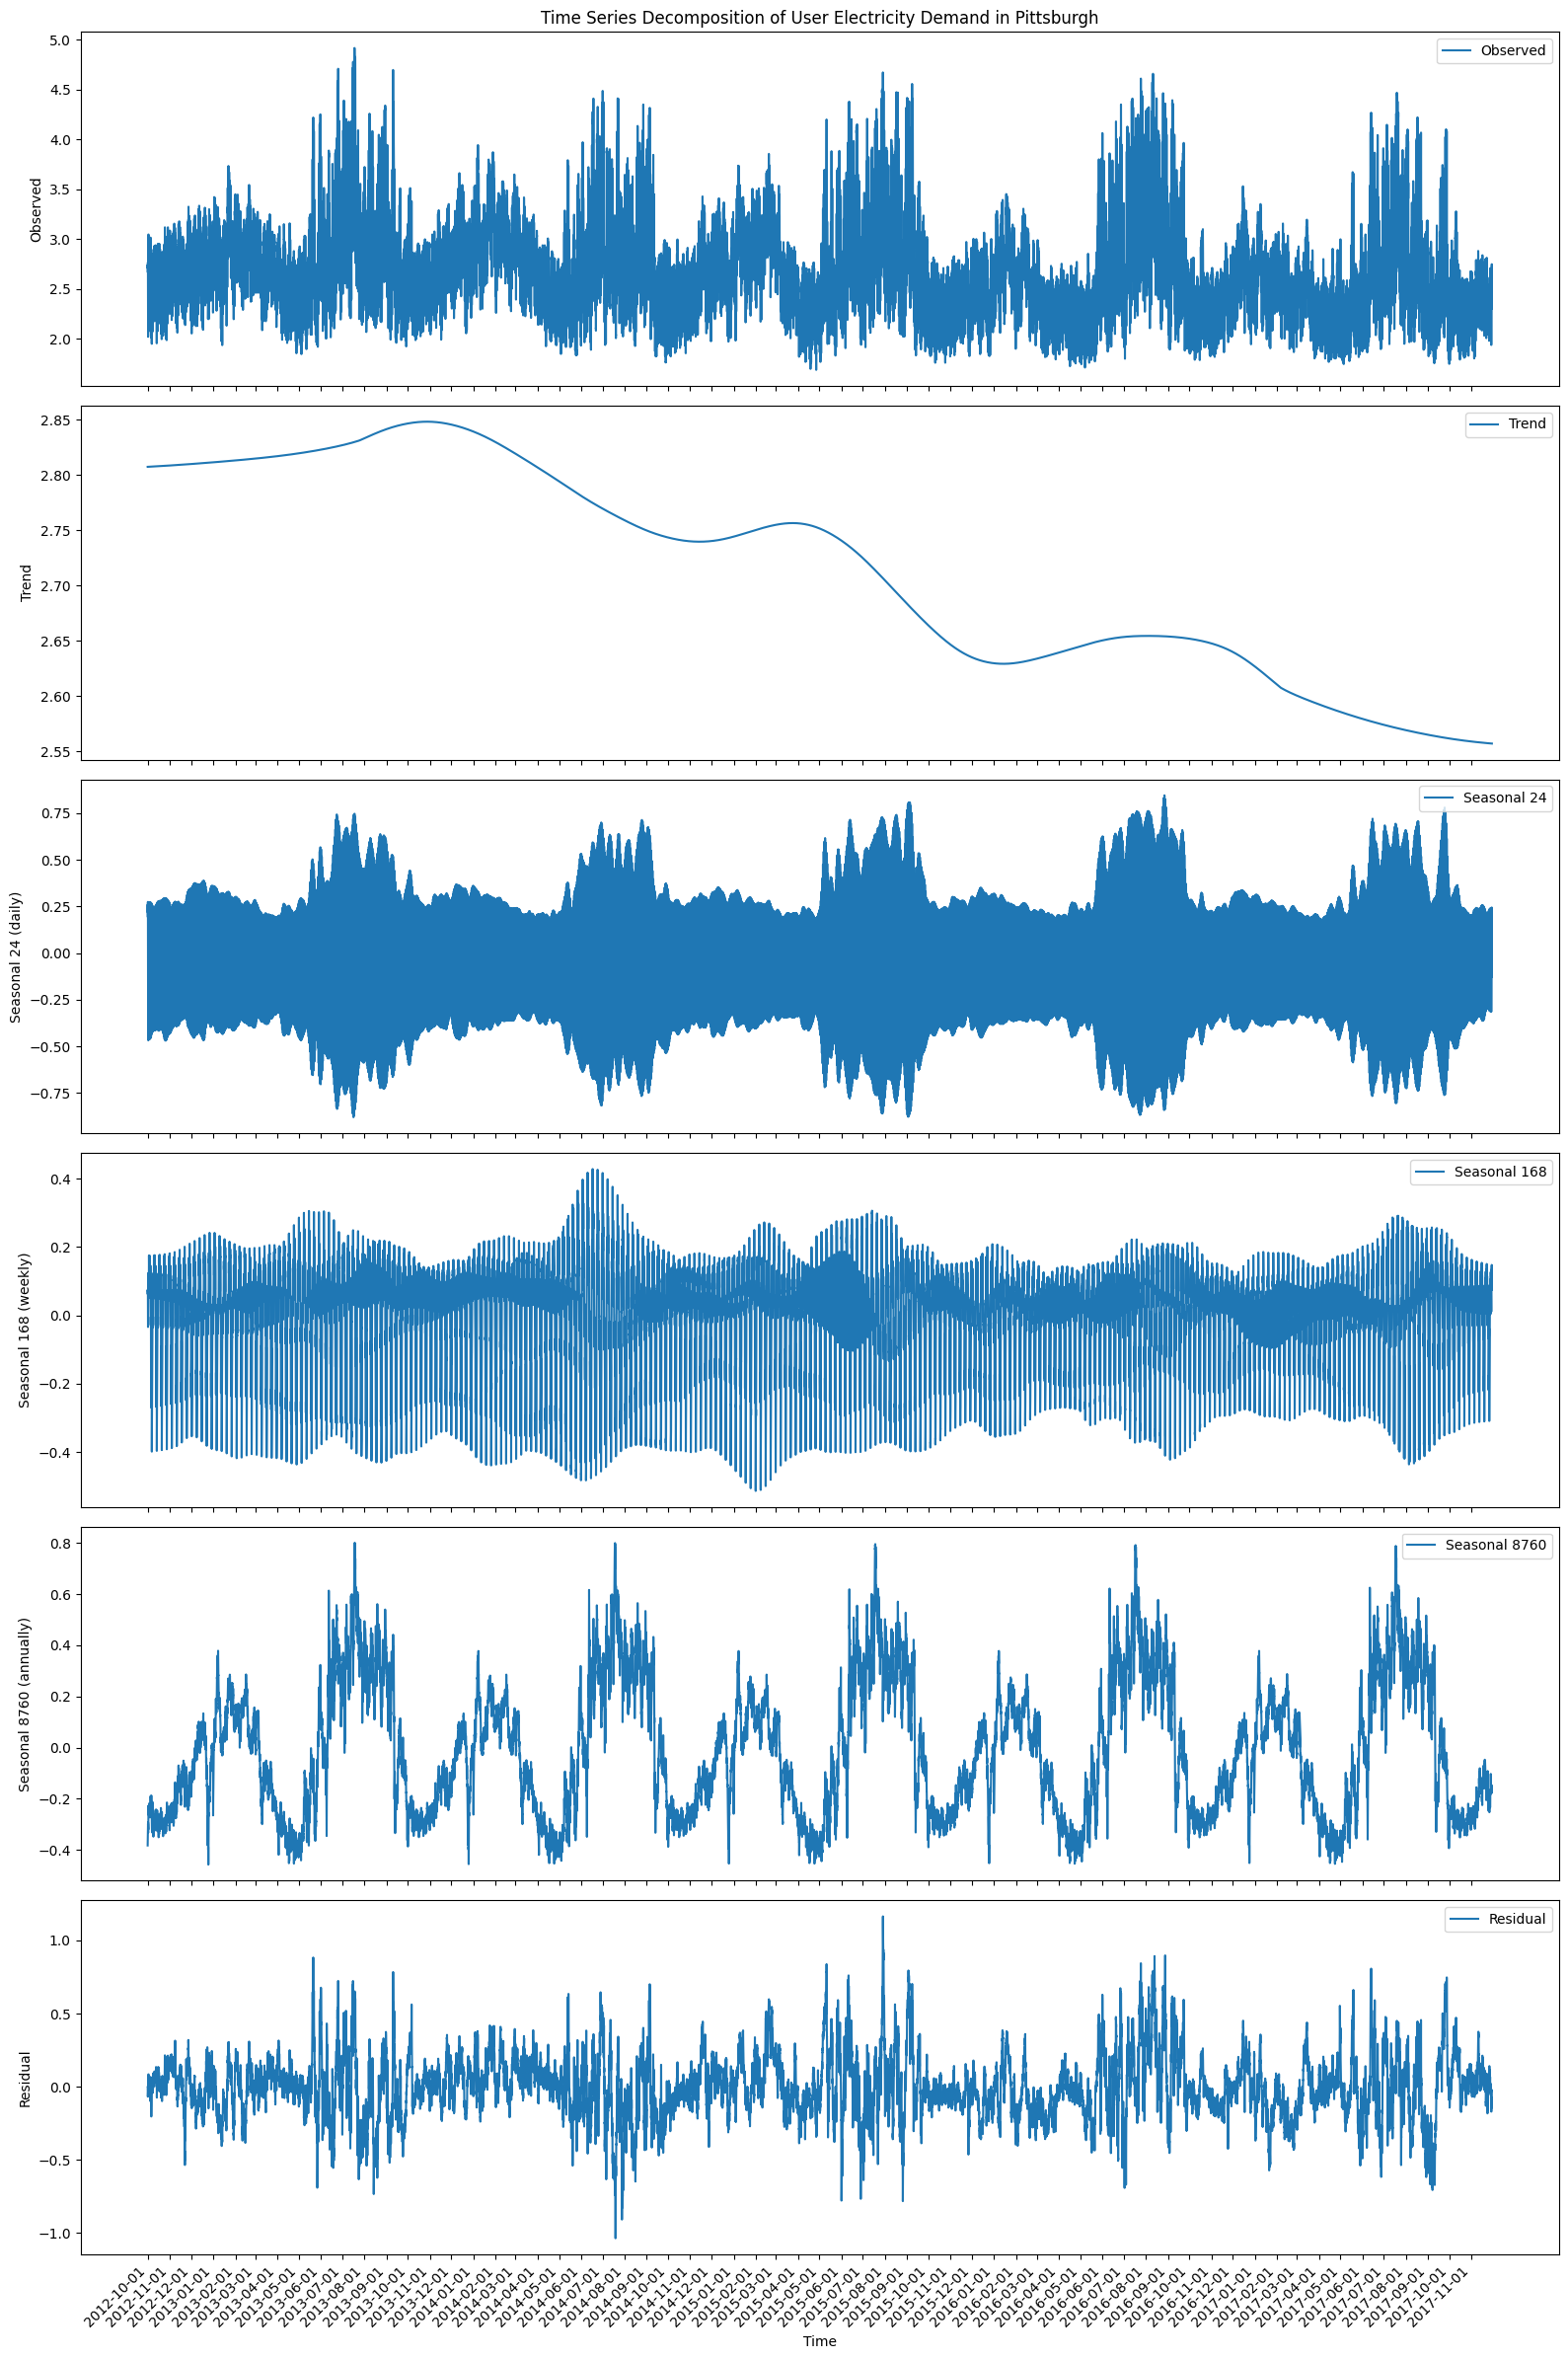

In [48]:
plt.figure(figsize=(16, 24))

# create 6 subplots
fig, axs = plt.subplots(6, 1, figsize=(16, 24), sharex=True)

# plot each component
sns.lineplot(data=result.observed, ax=axs[0], label='Observed')
sns.lineplot(data=result.trend, ax=axs[1], label='Trend')
sns.lineplot(data=result.seasonal['seasonal_24'], ax=axs[2], label='Seasonal 24')
sns.lineplot(data=result.seasonal['seasonal_168'], ax=axs[3], label='Seasonal 168')
sns.lineplot(data=result.seasonal['seasonal_8760'], ax=axs[4], label='Seasonal 8760')
sns.lineplot(data=result.resid, ax=axs[5], label='Residual')

# set labels and title
axs[0].set_ylabel('Observed')
axs[1].set_ylabel('Trend')
axs[2].set_ylabel('Seasonal 24 (daily)')
axs[3].set_ylabel('Seasonal 168 (weekly)')
axs[4].set_ylabel('Seasonal 8760 (annually)')
axs[5].set_ylabel('Residual')
axs[0].set_title('Time Series Decomposition of User Electricity Demand in Pittsburgh')

# add legends
for ax in axs:
    ax.legend(loc='upper right')

# set x axis ticks and labels
ax_last = axs[-1]
ax_last.set_xlabel('Time')

# create date range for x axis ticks
start_date = result.observed.index[0]
end_date = result.observed.index[-1]
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

ax_last.set_xticks(date_range)

# customize x axis label formatting
def format_date(x, pos=None):
    date = pd.to_datetime(x)
    if date.month == 1:
        return date.strftime('%Y %b')
    else:
        return date.strftime('%b')

# rotate and align the tick labels
plt.setp(ax_last.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [52]:
# prepare results to plot
df_results = result.seasonal.copy()

# reset index
df_results.reset_index(drop=False, inplace=True)

# hour of the day column
df_results['hour_of_day'] = df_results['datetime'].dt.hour

# hour of the week col
df_results['hour_of_week'] = df_results['datetime'].dt.dayofweek * 24 + df_results['hour_of_day']

df_results.head()

datetime  seasonal_24  seasonal_168  seasonal_8760  \
0 2012-10-01 08:00:00-04:00     0.221980      0.073038      -0.382984   
1 2012-10-01 09:00:00-04:00     0.240095      0.062681      -0.372894   
2 2012-10-01 10:00:00-04:00     0.251760      0.065843      -0.374739   
3 2012-10-01 11:00:00-04:00     0.260961      0.062041      -0.360898   
4 2012-10-01 12:00:00-04:00     0.230229      0.073878      -0.342947   

   hour_of_day  hour_of_week  
0            8             8  
1            9             9  
2           10            10  
3           11            11  
4           12            12

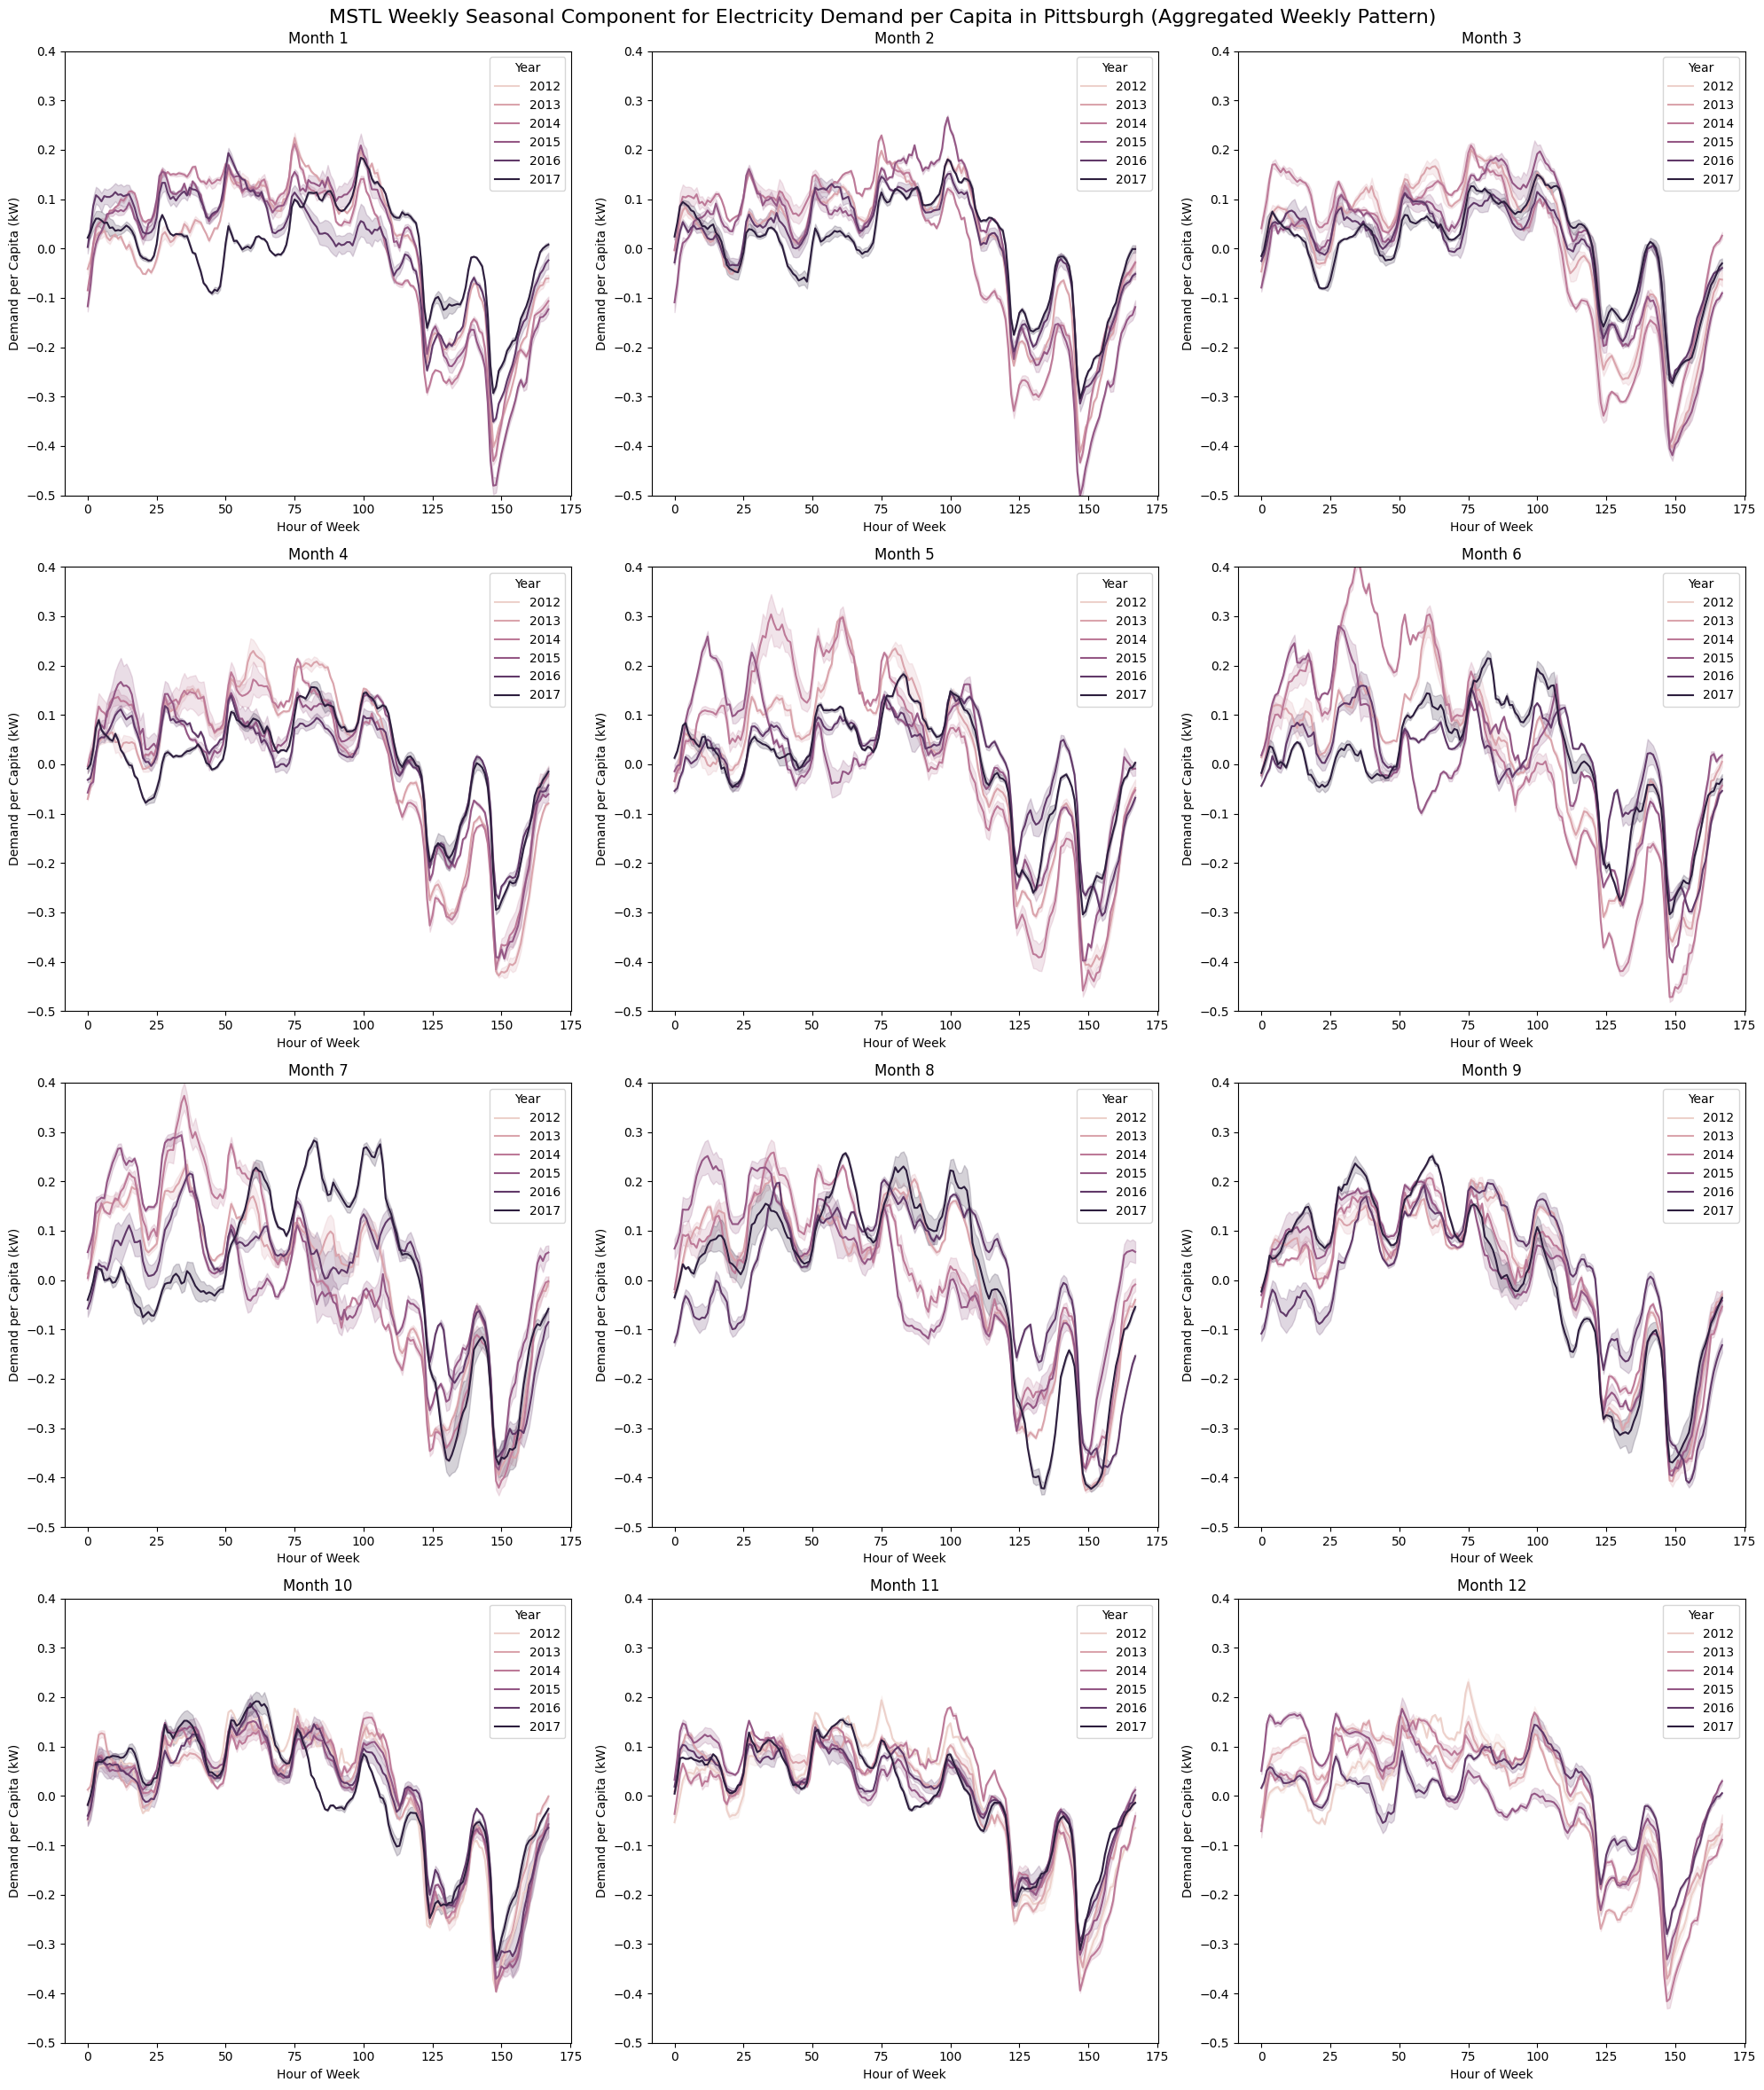

In [62]:
# create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 24))
fig.suptitle('MSTL Weekly Seasonal Component for Electricity Demand per Capita in Pittsburgh (Aggregated Weekly Pattern)\n', fontsize=16)

# flatten the axes array for easier iteration
axes = axes.flatten()

# plot energy load per capita for each month
for i, ax in enumerate(axes, start=1):
    sns.lineplot(
        data=df_results[df_results['datetime'].dt.month == i],
        x='hour_of_week',
        y='seasonal_168',
        hue=df_results['datetime'].dt.year,
        # errorbar=None,
        linewidth=1.5,
        ax=ax
    )

    # customize each subplot
    ax.set_title(f'Month {i}')
    ax.set_xlabel('Hour of Week')
    ax.set_ylabel('Demand per Capita (kW)')
    ax.set_ylim(-0.5, 0.4) # unify scale
    ax.legend(title='Year', loc='upper right')

# adjust layout and show the plot
plt.tight_layout()
plt.show()

We can see for the MSTL weekly seasonal component a better overlap for different years. There is still a small presence of dayly cycle on the envelope.

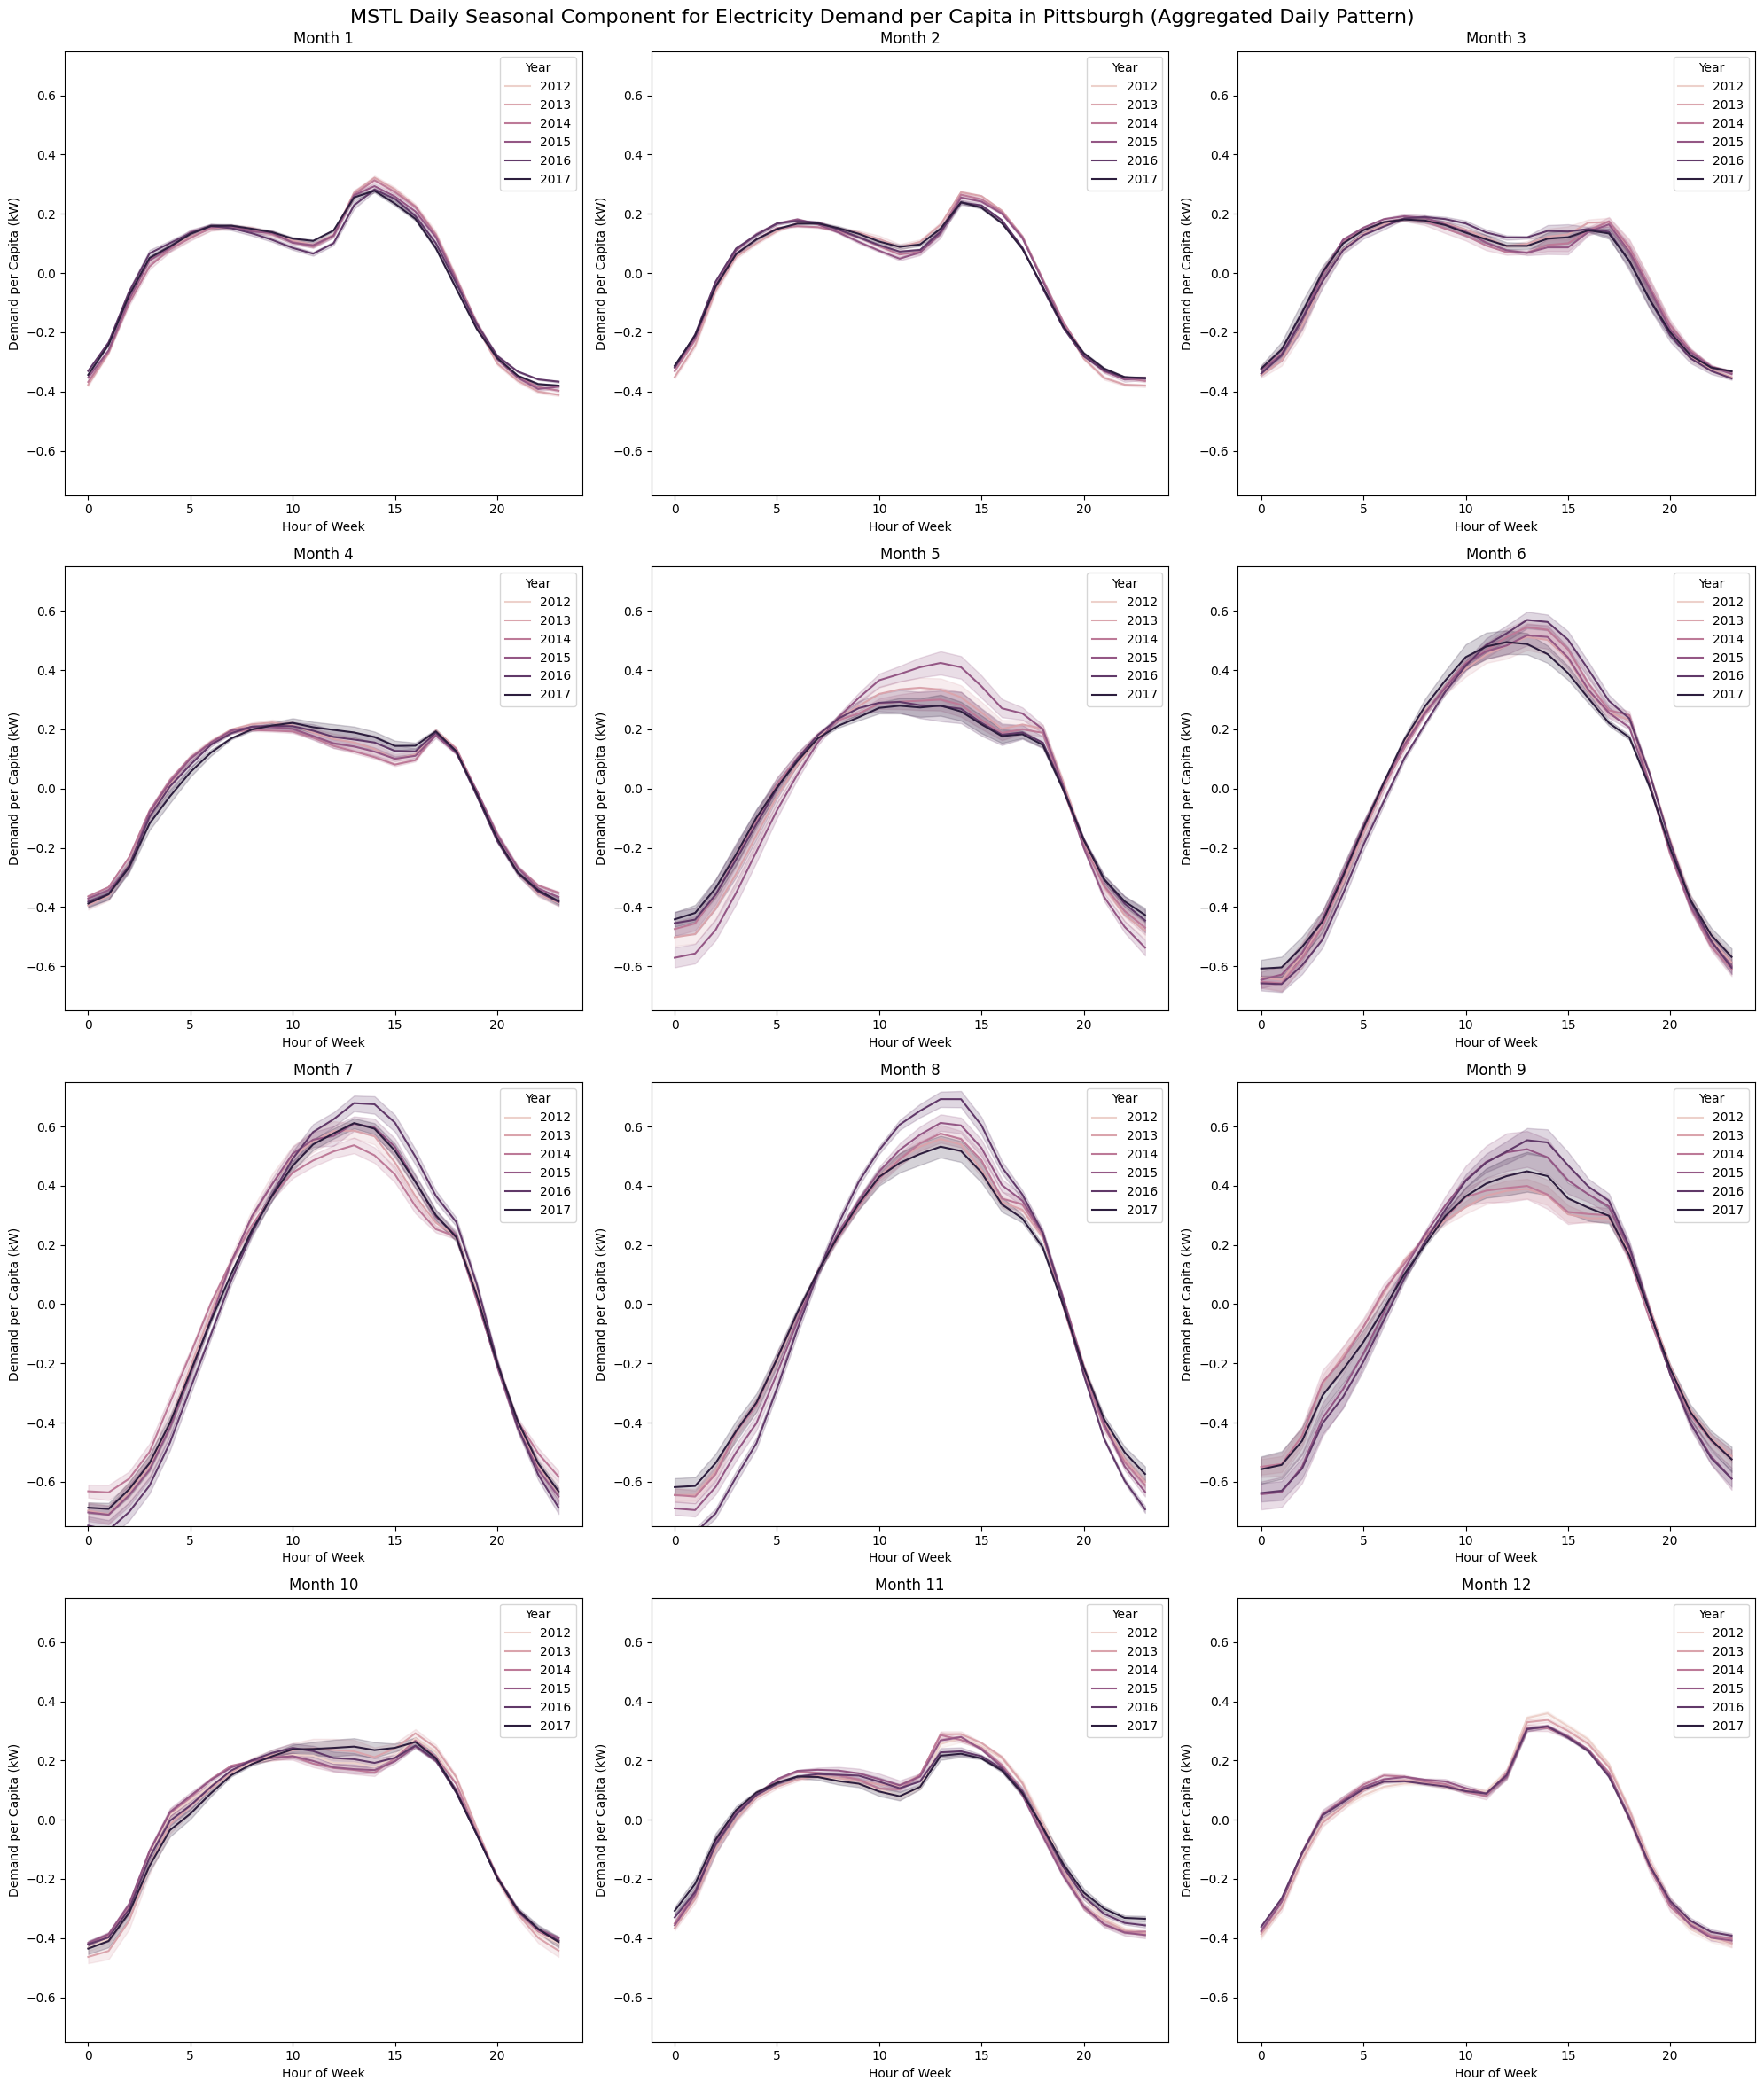

In [61]:
# create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(20, 24))
fig.suptitle('MSTL Daily Seasonal Component for Electricity Demand per Capita in Pittsburgh (Aggregated Daily Pattern)\n', fontsize=16)

# flatten the axes array for easier iteration
axes = axes.flatten()

# plot energy load per capita for each month
for i, ax in enumerate(axes, start=1):
    sns.lineplot(
        data=df_results[df_results['datetime'].dt.month == i],
        x='hour_of_day',
        y='seasonal_24',
        hue=df_results['datetime'].dt.year,
        # errorbar=None,
        linewidth=1.5,
        ax=ax
    )

    # customize each subplot
    ax.set_title(f'Month {i}')
    ax.set_xlabel('Hour of Week')
    ax.set_ylabel('Demand per Capita (kW)')
    ax.set_ylim(-0.75, 0.75) # unify scale
    ax.legend(title='Year', loc='upper right')

# adjust layout and show the plot
plt.tight_layout()
plt.show()

The deployment of the MSTL daily seasonal component is outstanding; we achieved a superb overlap for that component (even with error bars). This method has done an excellent job isolating the 24-hour seasonal pattern.

This last plot provides a perfect depiction of human activity hours. First, we can notice the sleeping patterns: the steeper curve at the beginning of the day reveals more people with approximately the same waking hour; during the night, that slope is less pronounced, indicating more dispersion. From October to March, around noon, there's a marked fall in activity for the lunch hour, followed by a steep increase reaching the maximum in activity.